# Continuing on the Dask Data structures

Dask offers several pythonic data structures to handle and operate with larger-than-memory data in a distributed system.
- `dask.bag`: distributed generic python list. The Dask equivalent to a PySpark RDD
- `dask.array`: distributed numpy arrays
- `dask.dataframe`: distributed pandas dataframes

All the high-level data structure APIs are optimized to exploit the DAG optimization features of the Dask scheduler, and thus rely on lazy computation.

## Start the Dask cluster

In [1]:
# set this variable with one of the following values

# -> 'local'
# -> 'docker_container'
# -> 'docker_cluster'

CLUSTER_TYPE ='docker_cluster'

In [2]:
%env CLUSTER_TYPE $CLUSTER_TYPE

env: CLUSTER_TYPE=docker_cluster


In [3]:
%%script bash --bg --out script_out

if [[ "$CLUSTER_TYPE" != "docker_cluster" ]]; then
    echo "Launching scheduler and worker"
    
    HOSTIP=`hostname -I | xargs`
    
    echo "dask-scheduler --host $HOSTIP --dashboard-address $HOSTIP:8787"
    
    # dask scheduler 
    dask-scheduler --host $HOSTIP --dashboard-address $HOSTIP:8787 &

    # dask worker
    dask-worker $HOSTIP:8786 --memory-limit 2GB --nworkers 2 &

fi

In [4]:
host_ip = !hostname -I | xargs
host_ip = host_ip[0]

In [5]:
from dask.distributed import Client

if CLUSTER_TYPE == 'local':
    
    client = Client()

elif CLUSTER_TYPE == 'docker_container':
    
    client = Client('{}:8786'.format(host_ip))
    
elif CLUSTER_TYPE == 'docker_cluster':
    
    # use the provided master
    client = Client('dask-scheduler:8786')
    
client

<Client: 'tcp://172.25.0.2:8786' processes=2 threads=2, memory=0.95 GiB>

## Dask DataFrame

The dask.dataframe API implements a blocked parallel DataFrame object that mimics a large subset of the Pandas DataFrame interfaces. 

One Dask DataFrame is comprised of many in-memory pandas DataFrames or Series hosted in all machines of the cluster.
A Dask DataFrame have its table separated (partitioned) along the index **\*** 

One operation on a Dask DataFrame triggers many Pandas operations on the constituent Pandas DataFrames in a way that is mindful of potential parallelism and memory constraints.

**\*** _Quick question. What kind of data partitioning are we talking about in this case? Vertical or Horizontal?_

### On the Data Partitioning

Partitioning is one of the key aspects of data management and processing in distributed systems (both in Spark, Dask, but also other frameworks as well).

Distributing our dataset into a large number of small partitions enables parallel processing in each node.
However, we should always remember that every single call the central scheduler performs to access the data on a remote partition (on a worker) requires time, ideally in the order of a few hundreds milliseconds.

As the user of the distributed processing system, it is **our** (not Dask's or Spark's) job to decide and optimize the number of partitions.
The distributed framework will first operate a choice or a guess, but the optimization of the performances depend on us making the right choice depending on the task.

For example, loading up data from a set of files, initially the number of partitions might be the exactly the number of the CSV files from which we are importing data. 
However, over time, as we reduce or increase the size of our DataFrames by filtering or joining, it may be wise to reconsider how many partitions we need to optimize Dask scheduler overhead. 


_There is always a cost associated in having too many or having too few partitions, but unfortunately, at the same time we don't have a single rule to decide which is the single "right" number of partitions._


As a rule of thumb, we can say that partitions should fit comfortably in memory.
But at the same time, they must not be too many, such as the central scheduler overhead becomes impacting the performances of our computation.

This means that the number of partition should be in a "reasonable region", and their number and size must be chosend by the user when starting optimizing the execution.

Let's start by reading a set of structured files (comma separated) in a DataFrame.

In pure Pandas, we have to loop over all files, open each one of them as a DataFrame, and concatenate all dataframes into a large DF.

The resulting DF is a single entity, stored in memory for single-threaded data access.

In [6]:
! ls datasets/accounts_csv

accounts.0.csv	accounts.1.csv	accounts.2.csv


In [7]:
! head -10 datasets/accounts_csv/accounts.0.csv

In [8]:
from glob import iglob
import pandas as pd
import os

path = os.path.join('datasets','accounts_csv','accounts.*.csv')

all_files = iglob(path, recursive=True)     

dataframes = (pd.read_csv(f) for f in all_files)

large_dataframe = pd.concat(dataframes, ignore_index=True)

In [9]:
large_dataframe

id   names  amount
0          9   Wendy      15
1         15  Victor      77
2        381     Bob    3064
3        358  Ingrid    2041
4        299   Kevin     204
...      ...     ...     ...
2999995  331   Laura     528
2999996  350   Kevin    6062
2999997  174  Yvonne     205
2999998   73  Xavier   -1691
2999999  422   Wendy     795

[3000000 rows x 3 columns]

In Dask, DataFrames can be created from a glob pattern using the wildcard `*`, so all files in the path matching that pattern will be read into the same Dask DataFrame.

We should remember that Dask DataFrames are a collection of Pandas dataframes, scattered across the workers.

When reading data into a DataFrame Dask will automatically create a number of jobs to read out the data in parallel.
It does this by creating one parallel job per chunk, which by default is the number of input files.
We can (and generally speaking should) however always think about how we want to partition our dataset, to exploits at best our workers.

In [10]:
import dask.dataframe as dd

path = os.path.join('datasets','accounts_csv','accounts.*.csv')

df = dd.read_csv(path)

As always, reading data is a lazy operation, posponed until we have something to compute.

Let's compute the lenght of the total DataFrame.

In [11]:
len(df)

3000000

Only at this stage, each file was loaded into a Pandas DataFrame and scattered on the nodes.

Computing `len()` meant that each Pandas DataFrame had `len` applied to it, and then the sub-result were aggregated and combined to provide the overall total length of the DF.

In [12]:
df

Dask DataFrame Structure:
                  id   names amount
npartitions=3                      
               int64  object  int64
                 ...     ...    ...
                 ...     ...    ...
                 ...     ...    ...
Dask Name: read-csv, 3 tasks

We can re-assign the number of partitions to the Dask DataFrame object using the `repartition` method

In [13]:
df = df.repartition(npartitions=8)

In [14]:
df

Dask DataFrame Structure:
                  id   names amount
npartitions=8                      
               int64  object  int64
                 ...     ...    ...
...              ...     ...    ...
                 ...     ...    ...
                 ...     ...    ...
Dask Name: repartition, 14 tasks

In [15]:
len(df)

3000000

In [16]:
df.npartitions

8

It is worth mentioning that differently from Pandas, Dask only reads in a sample from the beginning of the file (or the list of files) to start inferring the Data Types.

These inferred datatypes are then enforced when reading all partitions, which may lead to *incorrect* datatype assignment!

Think for instance in the case we start reading a csv file for which the first $n$ entries of a column are all integers, but the column is actually supposed to be a _string_ type.

In [17]:
df = dd.read_csv(os.path.join('datasets', 'nycflights', '*.csv'),
                 parse_dates={'Date': [0, 1, 2]})

In [18]:
df.dtypes

Date                 datetime64[ns]
DayOfWeek                     int64
DepTime                     float64
CRSDepTime                    int64
ArrTime                     float64
CRSArrTime                    int64
UniqueCarrier                object
FlightNum                     int64
TailNum                     float64
ActualElapsedTime           float64
CRSElapsedTime                int64
AirTime                     float64
ArrDelay                    float64
DepDelay                    float64
Origin                       object
Dest                         object
Distance                    float64
TaxiIn                      float64
TaxiOut                     float64
Cancelled                     int64
Diverted                      int64
dtype: object

In [19]:
df.head()

Date  DayOfWeek  DepTime  CRSDepTime  ArrTime  CRSArrTime  \
0 1993-01-29          5   1055.0        1055   1228.0        1212   
1 1993-01-30          6   1052.0        1055   1214.0        1212   
2 1993-01-31          7   1103.0        1055   1213.0        1212   
3 1993-01-03          7   1736.0        1729   1838.0        1831   
4 1993-01-04          1   1730.0        1729   1825.0        1831   

  UniqueCarrier  FlightNum  TailNum  ActualElapsedTime  ...  AirTime  \
0            US         66      NaN               93.0  ...      NaN   
1            US         66      NaN               82.0  ...      NaN   
2            US         66      NaN               70.0  ...      NaN   
3            US         70      NaN               62.0  ...      NaN   
4            US         70      NaN               55.0  ...      NaN   

   ArrDelay  DepDelay  Origin Dest Distance  TaxiIn  TaxiOut  Cancelled  \
0      16.0       0.0     EWR  BUF    282.0     NaN      NaN          0   
1       2.0      -3.0     EWR  BUF    282.0     NaN      NaN          0   
2       1.0       8.0     EWR  BUF    282.0     NaN      NaN          0   
3       7.0       7.0     LGA  SYR    198.0     NaN      NaN          0   
4      -6.0       1.0     LGA  SYR    198.0     NaN      NaN          0   

   Diverted  
0         0  
1         0  
2         0  
3         0  
4         0  

[5 rows x 21 columns]

In [20]:
df.tail()

ValueError: Mismatched dtypes found in `pd.read_csv`/`pd.read_table`.

+----------------+---------+----------+
| Column         | Found   | Expected |
+----------------+---------+----------+
| CRSElapsedTime | float64 | int64    |
| TailNum        | object  | float64  |
+----------------+---------+----------+

The following columns also raised exceptions on conversion:

- TailNum
  ValueError("could not convert string to float: 'N54711'")

Usually this is due to dask's dtype inference failing, and
*may* be fixed by specifying dtypes manually by adding:

dtype={'CRSElapsedTime': 'float64',
       'TailNum': 'object'}

to the call to `read_csv`/`read_table`.

In this case, the datatypes inferred for `CRSElapsedTime` and `TailNum` are in fact incorrect. 

We can however force Dask to interpret the datatypes as we want them to be using the `dtype` assignment.
This is usually the most viable and robust solution, but not the only one.

We could also:
- Increase the size of the sample used to infer the datatypes
- Use `assume_missing` to make Dask assume that columns inferred to be `int` (which don't allow missing values) are actually `floats` (which do allow missing values)

However, in general the best solution is still to hard-code the datatypes.

In [21]:
df = dd.read_csv(os.path.join('datasets', 'nycflights', '*.csv'),
                 parse_dates={'Date': [0, 1, 2]},
                 dtype={'TailNum': str,
                        'CRSElapsedTime': float})

In [22]:
df = df.repartition(8)

In [23]:
df.tail()

Date  DayOfWeek  DepTime  CRSDepTime  ArrTime  CRSArrTime  \
269176 1999-12-27          1   1645.0        1645   1830.0        1901   
269177 1999-12-28          2   1726.0        1645   1928.0        1901   
269178 1999-12-29          3   1646.0        1645   1846.0        1901   
269179 1999-12-30          4   1651.0        1645   1908.0        1901   
269180 1999-12-31          5   1642.0        1645   1851.0        1901   

       UniqueCarrier  FlightNum TailNum  ActualElapsedTime  ...  AirTime  \
269176            UA       1753  N516UA              225.0  ...    205.0   
269177            UA       1753  N504UA              242.0  ...    214.0   
269178            UA       1753  N592UA              240.0  ...    220.0   
269179            UA       1753  N575UA              257.0  ...    233.0   
269180            UA       1753  N539UA              249.0  ...    232.0   

        ArrDelay  DepDelay  Origin Dest Distance  TaxiIn  TaxiOut  Cancelled  \
269176     -31.0       0.0     LGA  DEN   1619.0     7.0     13.0          0   
269177      27.0      41.0     LGA  DEN   1619.0     5.0     23.0          0   
269178     -15.0       1.0     LGA  DEN   1619.0     5.0     15.0          0   
269179       7.0       6.0     LGA  DEN   1619.0     5.0     19.0          0   
269180     -10.0      -3.0     LGA  DEN   1619.0     6.0     11.0          0   

        Diverted  
269176         0  
269177         0  
269178         0  
269179         0  
269180         0  

[5 rows x 21 columns]

While on the topic of reading out data from files, it is worth mentioning that Dask offers a vast range of APIs for importing structured data from a multitude of file formats into a DataFrame object, including:
- csv
- json
- avro
- parquet

For a more extensive list, check the official documentation at the [link](https://docs.dask.org/en/stable/dataframe-create.html).

### Computations with Dask DataFrames

Dask DataFrame almost 1-to-1 copy the Pandas DataFrame API.
Effectively, Dask provides a wrapper around the Pandas API in order to manage the same calls on the distributed collection of Pandas DataFrames, which in our case are the partitions or our dataset.

Clearly, using Dask DataFrame is useful only up to the measure where Pandas shows its limits, either due to data size (larger than memory datasets) or computation speed (running a task that could be parallelized efficiently).

Whenever working with small datasets and not-really parallelizable tasks, Pandas will always be the best choice.

For this very reason, the usual computing pattern when dealing with Dask dataframe is simply the following:
1. Use `Dask Bag` to ingest data from semi/unstructured sources and pre-process it into Dask DataFrames
1. Use `Dask DataFrame` for parallel computations and data reduction to produce a resulting slimmed DataFrame that can be fit in memory, then convert it into a single Pandas DataFrame
1. Use `Pandas` for simple (yet fast) DataFrames operations for non-parallelizable tasks


We can always retrieve data from all partitions and create a Pandas DataFrame from a Dask DataFrame using the `compute` method on the DataFrame itself.

At this point this should not come as a surprise, but this operation should be done very carefully, and only at the right time, when we have reduced our very large (possibly TeraBytes-large) Dask DataFrame to something meaningful to be stored in our computers' memory.

In [24]:
pandas_df = df.compute()
pandas_df

Date  DayOfWeek  DepTime  CRSDepTime  ArrTime  CRSArrTime  \
0      1993-01-29          5   1055.0        1055   1228.0        1212   
1      1993-01-30          6   1052.0        1055   1214.0        1212   
2      1993-01-31          7   1103.0        1055   1213.0        1212   
3      1993-01-03          7   1736.0        1729   1838.0        1831   
4      1993-01-04          1   1730.0        1729   1825.0        1831   
...           ...        ...      ...         ...      ...         ...   
269176 1999-12-27          1   1645.0        1645   1830.0        1901   
269177 1999-12-28          2   1726.0        1645   1928.0        1901   
269178 1999-12-29          3   1646.0        1645   1846.0        1901   
269179 1999-12-30          4   1651.0        1645   1908.0        1901   
269180 1999-12-31          5   1642.0        1645   1851.0        1901   

       UniqueCarrier  FlightNum TailNum  ActualElapsedTime  ...  AirTime  \
0                 US         66     NaN               93.0  ...      NaN   
1                 US         66     NaN               82.0  ...      NaN   
2                 US         66     NaN               70.0  ...      NaN   
3                 US         70     NaN               62.0  ...      NaN   
4                 US         70     NaN               55.0  ...      NaN   
...              ...        ...     ...                ...  ...      ...   
269176            UA       1753  N516UA              225.0  ...    205.0   
269177            UA       1753  N504UA              242.0  ...    214.0   
269178            UA       1753  N592UA              240.0  ...    220.0   
269179            UA       1753  N575UA              257.0  ...    233.0   
269180            UA       1753  N539UA              249.0  ...    232.0   

        ArrDelay  DepDelay  Origin Dest Distance  TaxiIn  TaxiOut  Cancelled  \
0           16.0       0.0     EWR  BUF    282.0     NaN      NaN          0   
1            2.0      -3.0     EWR  BUF    282.0     NaN      NaN          0   
2            1.0       8.0     EWR  BUF    282.0     NaN      NaN          0   
3            7.0       7.0     LGA  SYR    198.0     NaN      NaN          0   
4           -6.0       1.0     LGA  SYR    198.0     NaN      NaN          0   
...          ...       ...     ...  ...      ...     ...      ...        ...   
269176     -31.0       0.0     LGA  DEN   1619.0     7.0     13.0          0   
269177      27.0      41.0     LGA  DEN   1619.0     5.0     23.0          0   
269178     -15.0       1.0     LGA  DEN   1619.0     5.0     15.0          0   
269179       7.0       6.0     LGA  DEN   1619.0     5.0     19.0          0   
269180     -10.0      -3.0     LGA  DEN   1619.0     6.0     11.0          0   

        Diverted  
0              0  
1              0  
2              0  
3              0  
4              0  
...          ...  
269176         0  
269177         0  
269178         0  
269179         0  
269180         0  

[528060 rows x 21 columns]

Let's work with basic DataFrame operations and inspect their impact in Dask vs Pandas.

In Dask, all operations on columns and individual items are easily parallelized, and thus very fast.

In [25]:
# retrieve the max of the DepDelay column
df.DepDelay.max().compute()

1435.0

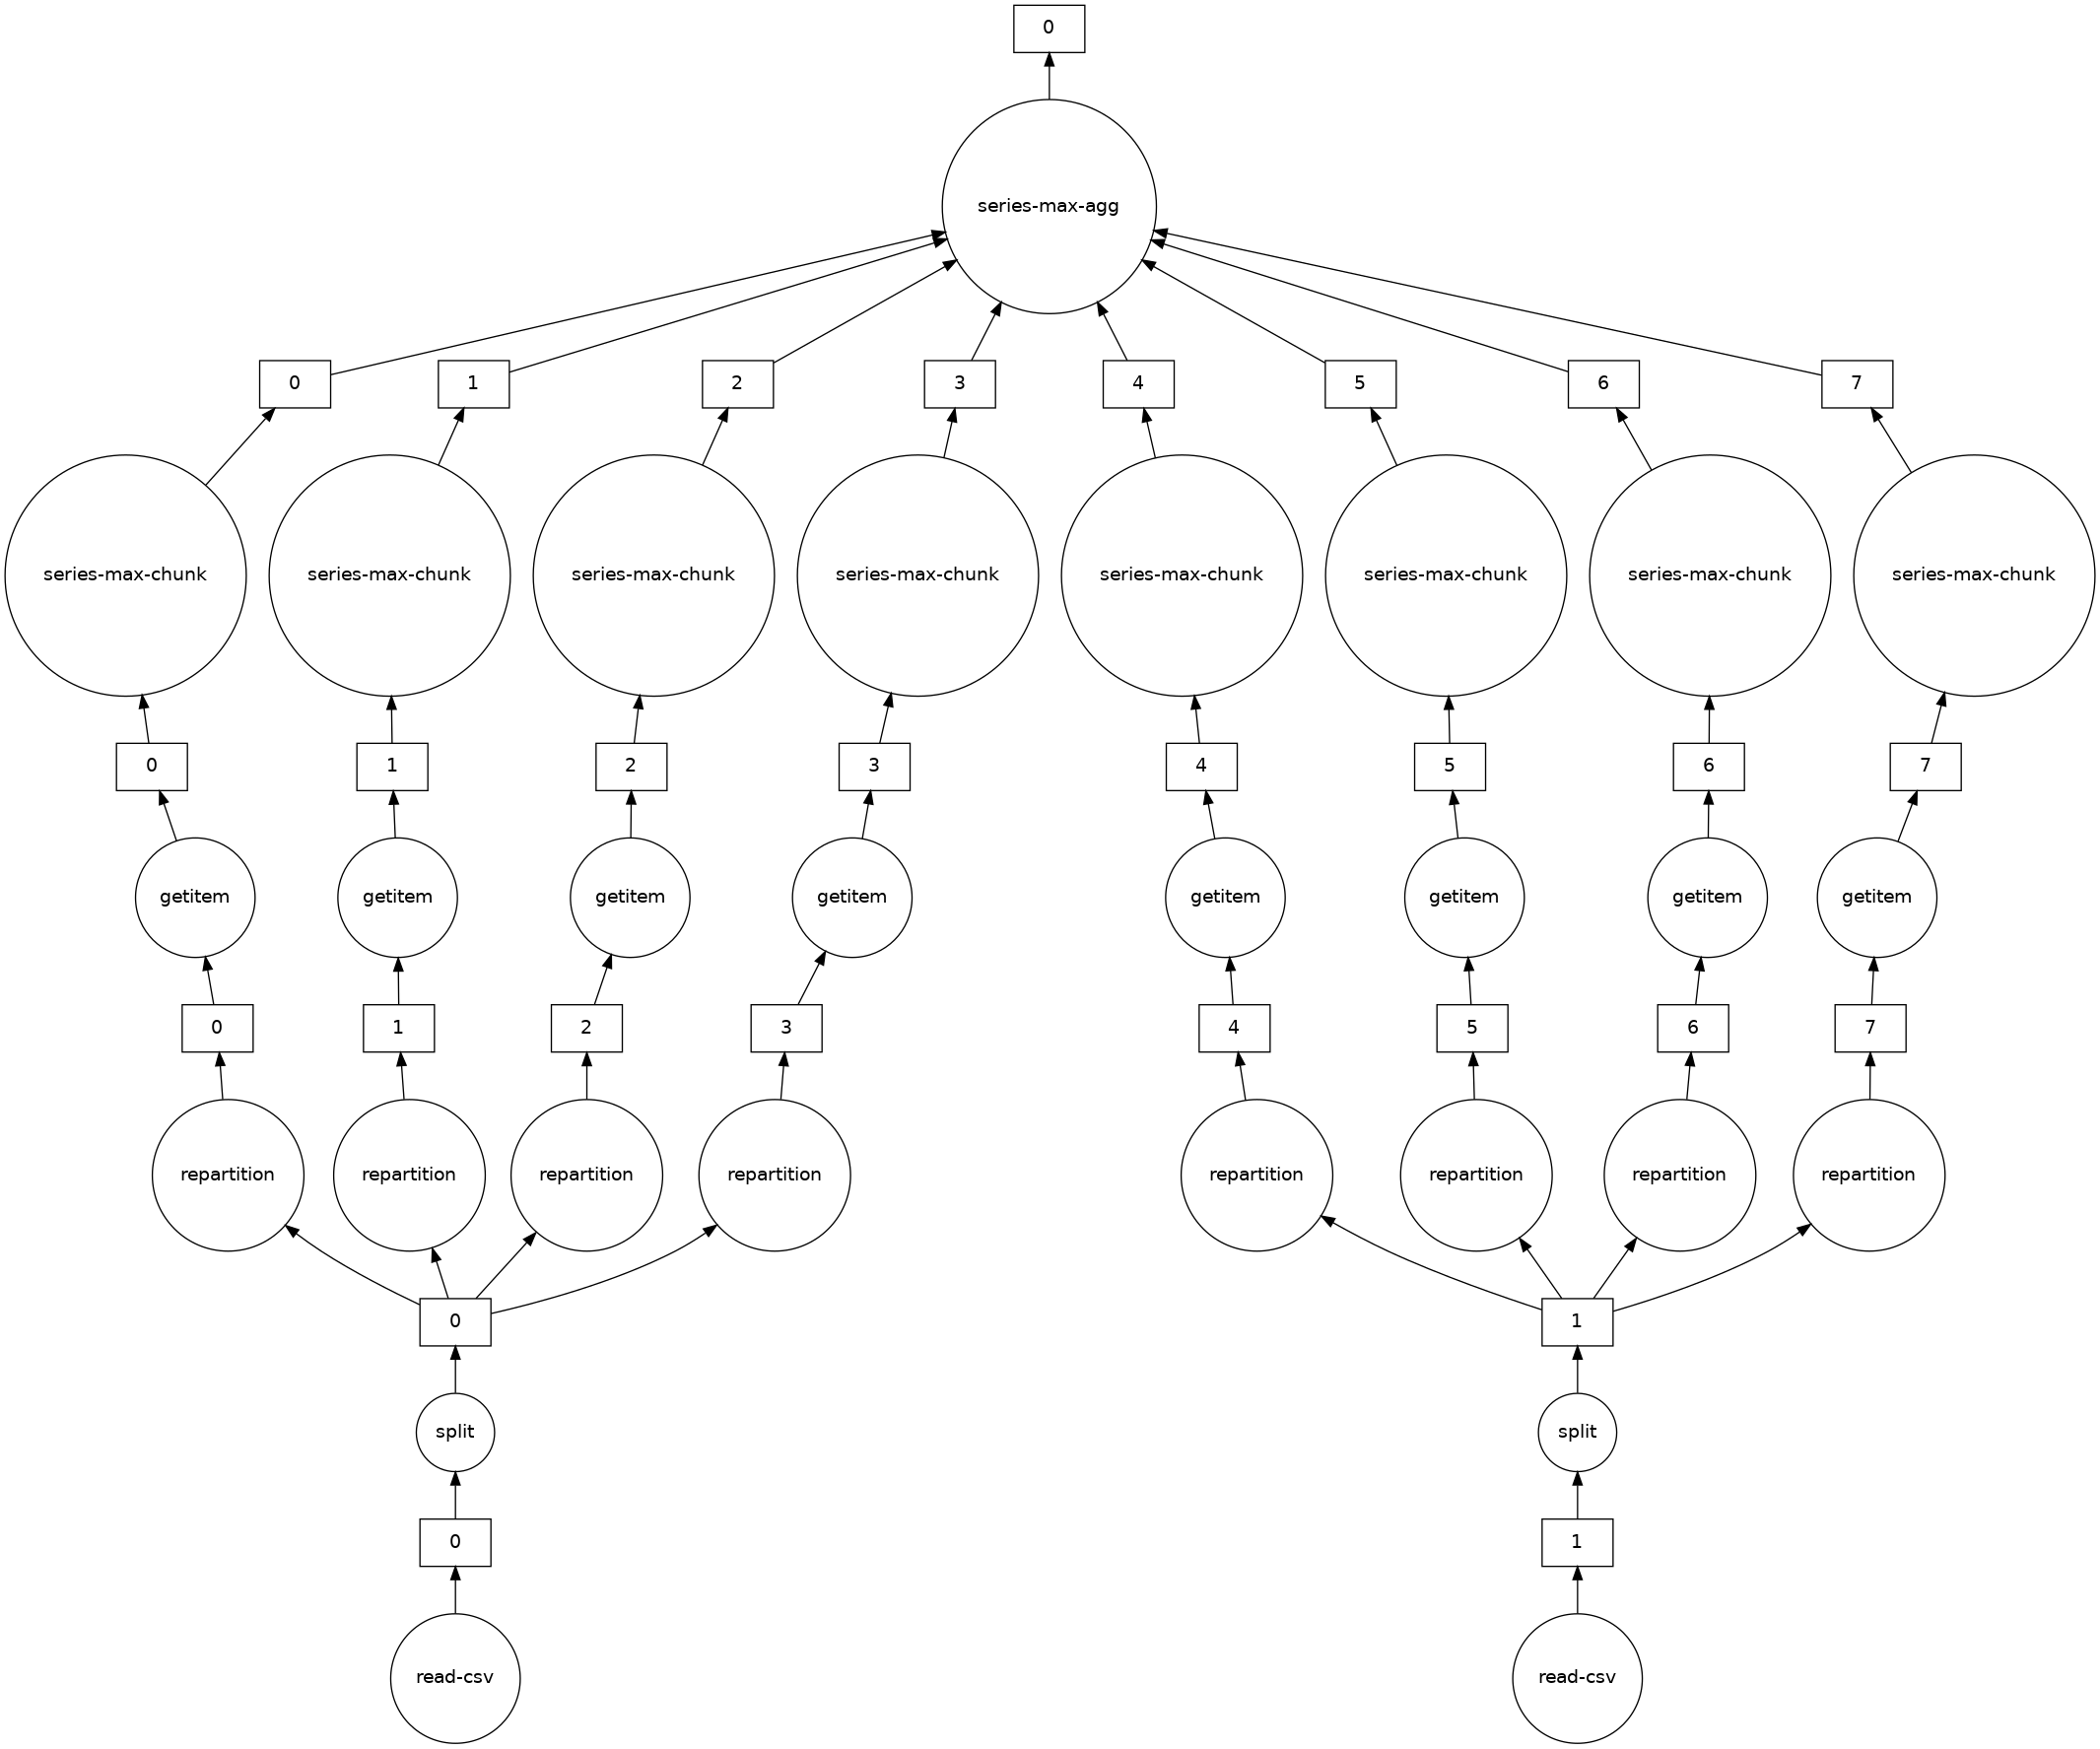

In [26]:
# visualize the graph for this operation
df.DepDelay.max().visualize()

In [27]:
# find the average arrival delay (ArrDelay) of all flights with carrier UnitedAirlines (UA)
df[df.UniqueCarrier == 'UA'].ArrDelay.mean().compute()

7.602844406707705

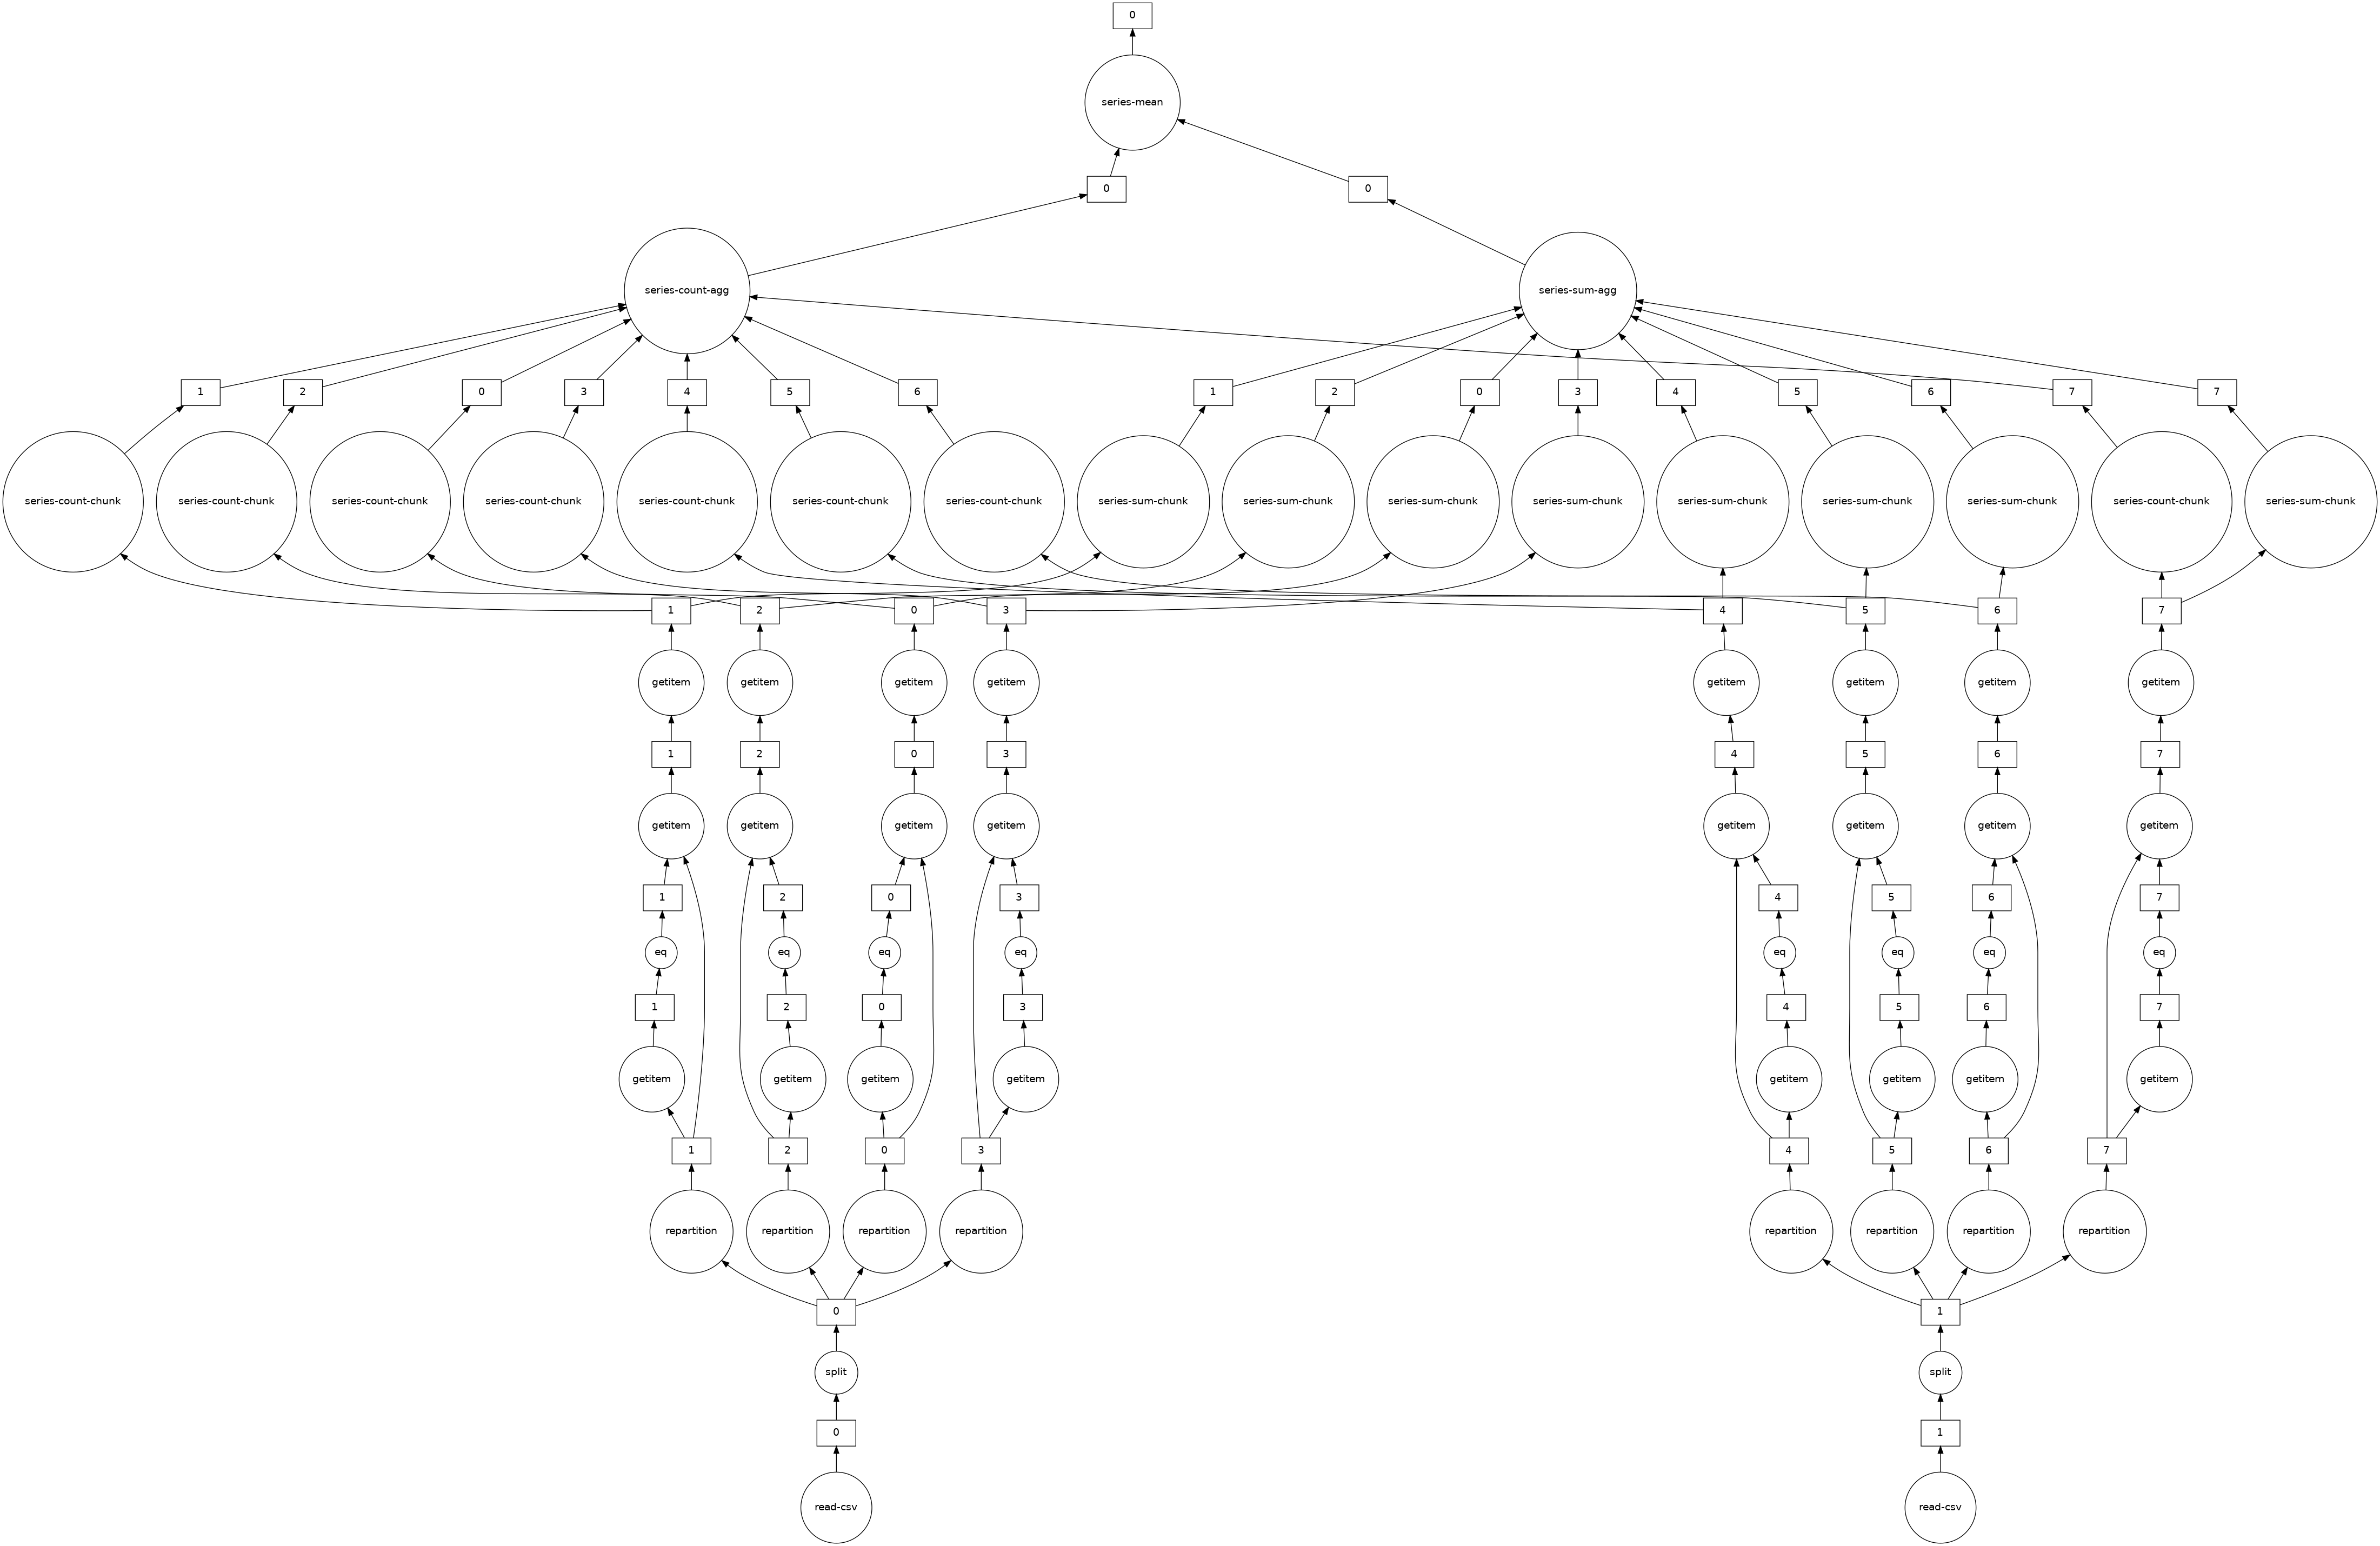

In [28]:
# visualize the last operation
df[df.UniqueCarrier == 'UA'].ArrDelay.mean().visualize()

Dask DataFrames also offer a smart implementation of most operations involving a minimal amount of shuffling, such as group based aggregations and merge operations.

This means that operations such as `groupby`, `resample`, `rolling` and other similar operations are still reasonably fast, even though they are produced with a large under-the-hood optimization.

In [30]:
# find the max airtime by combinations of origin and destination
df.groupby(['Origin', 'Dest']).AirTime.max().compute()

Origin  Dest
EWR     ATL     213.0
        BDL       NaN
        BNA     166.0
        BOS     180.0
        BTV       NaN
                ...  
LGA     HOU     294.0
EWR     SJC     377.0
LGA     LWB      84.0
EWR     SAV     118.0
        TUS     297.0
Name: AirTime, Length: 175, dtype: float64

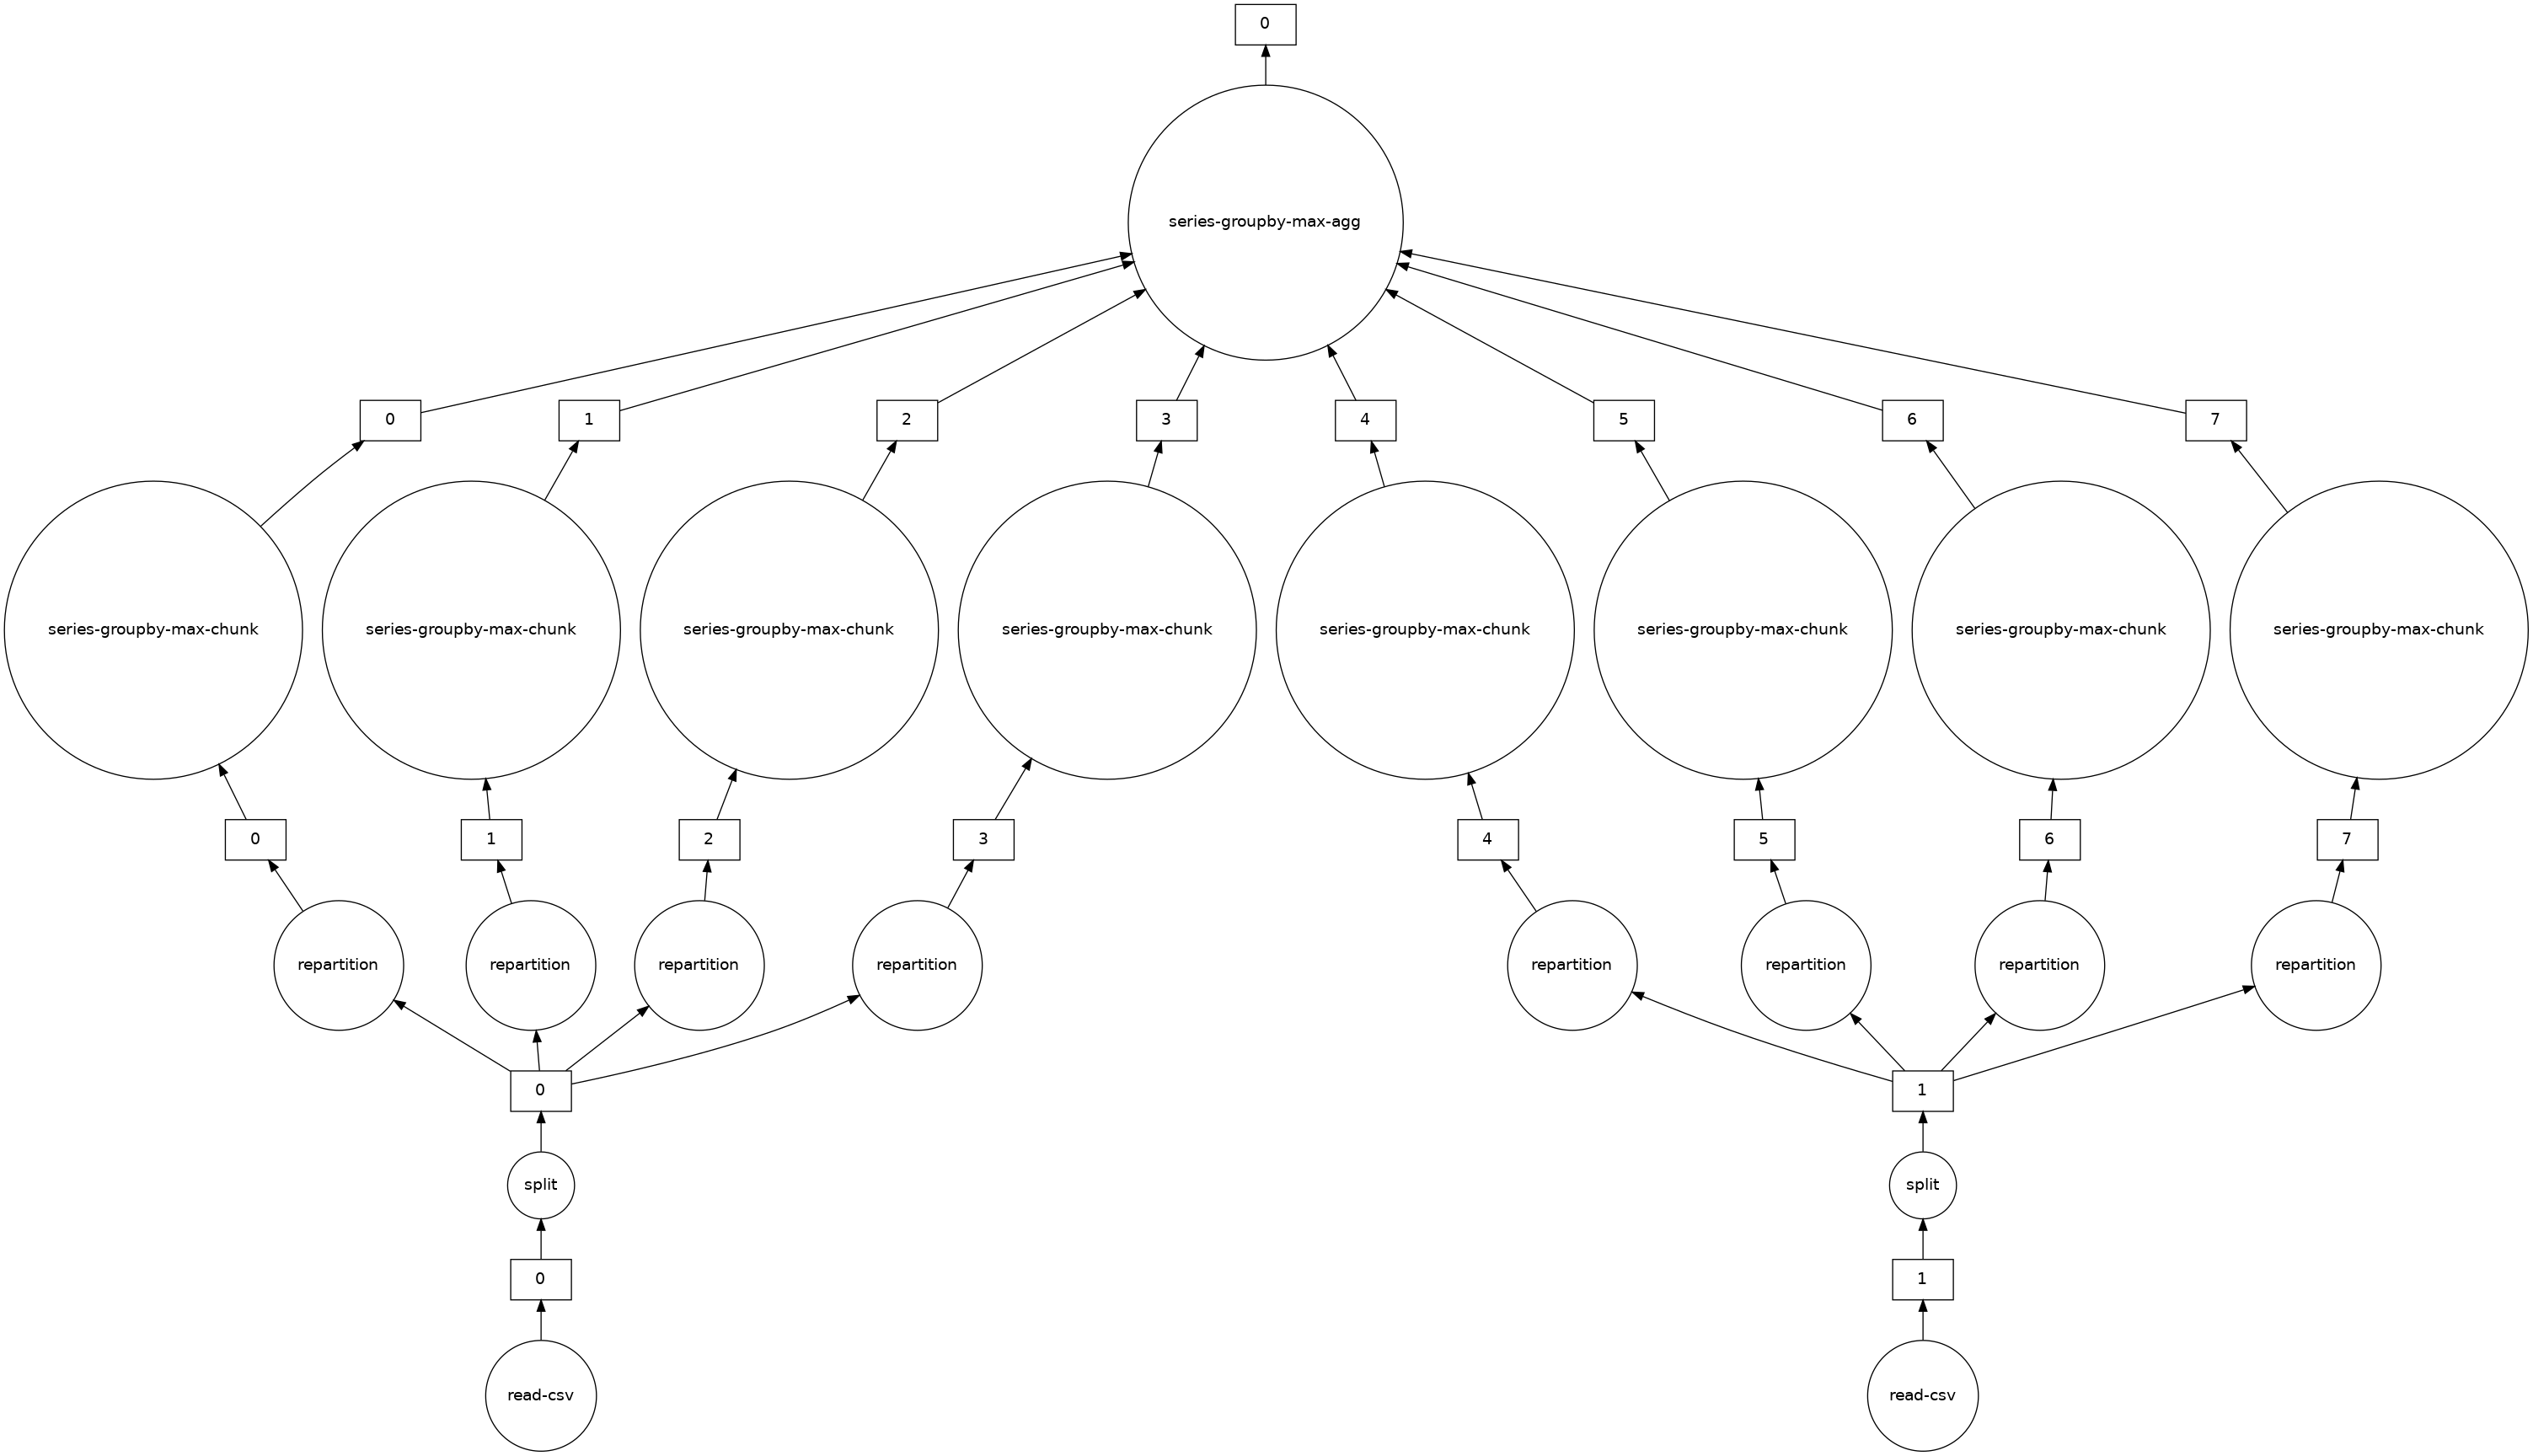

In [31]:
# visualize the last operation
df.groupby(['Origin', 'Dest']).AirTime.max().visualize()

As we can see from the graph, the `groupby` method returns a single object from the computation, stored in a single partition.
This is usually a fair choice, as it is normally considered that the result of a groupby aggregation is small enough to be stored into a single worker memory, thus not requiring the result to be split into multiple partitions.


However, it may happen that the retuned object is very large, depending on the input datasets, and we can optimize the number of output partitions by using the `split_out` argument.


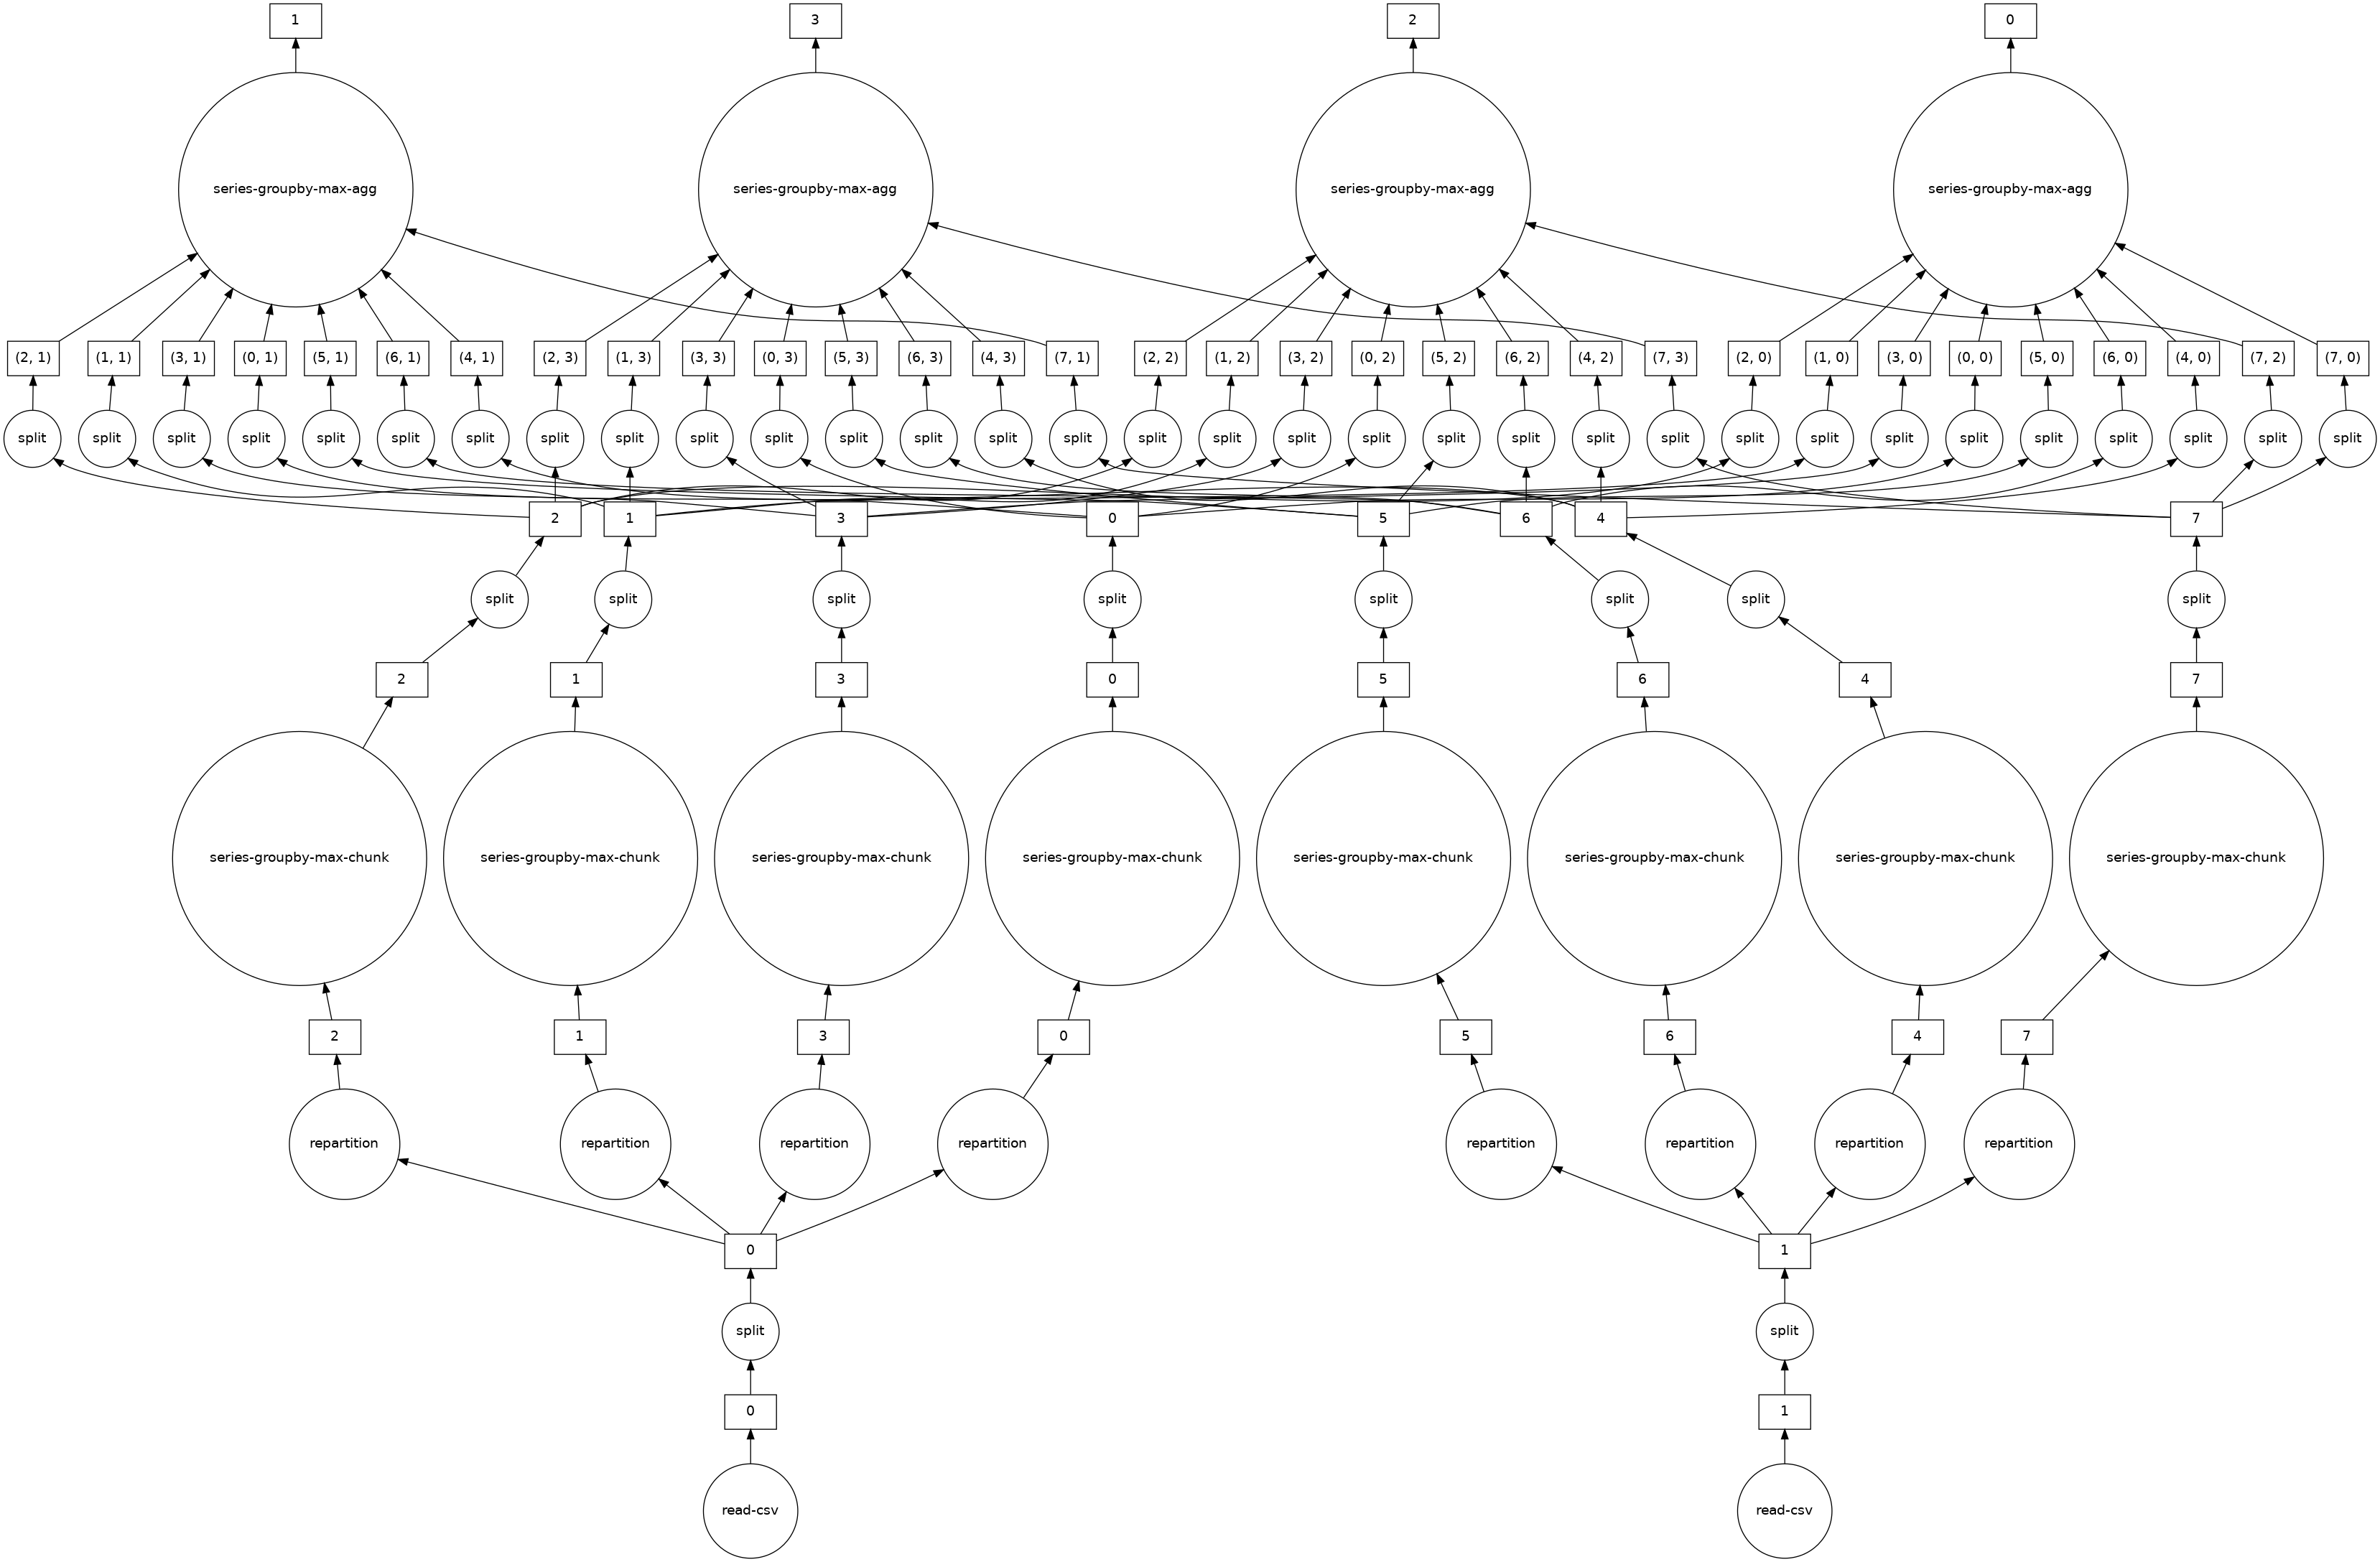

In [32]:
# find the max airtime by combinations of origin and destination
# split the result of the groupby operation in 4 partitions
df.groupby(['Origin','Dest']).AirTime.max(split_out=4).visualize()

Note: Dask also supports the same aggregate syntax as Pandas to run sevearal aggregations at the same time on the same group.

In [33]:
df.groupby(['Origin','Dest']).AirTime.aggregate(['mean','std']).compute()

mean        std
Origin Dest                       
EWR    ATL   110.752243  11.771768
       BDL          NaN        NaN
       BNA   109.915950   7.836804
       BOS    40.255256   7.425724
       BTV          NaN        NaN
...                 ...        ...
LGA    HOU   201.312367  14.125277
EWR    SJC   339.879365  14.441339
LGA    LWB    67.974359   5.219778
EWR    SAV   107.785714   6.715981
       TUS   279.500000  24.748737

[175 rows x 2 columns]

There are clearly operations for which the mapping with the standard Pandas APIs cannot hold.

For instance, the slicing and feature-based indexing based on `loc` does work as expected, but the potition-based indexing operator `iloc` does not really work as one would expect in Dask vs Pandas.

In [34]:
df.loc[df['Dest']=='DEN',['UniqueCarrier']].compute()

UniqueCarrier
7081              TW
7082              TW
7083              TW
7084              TW
7085              TW
...              ...
269176            UA
269177            UA
269178            UA
269179            UA
269180            UA

[13581 rows x 1 columns]

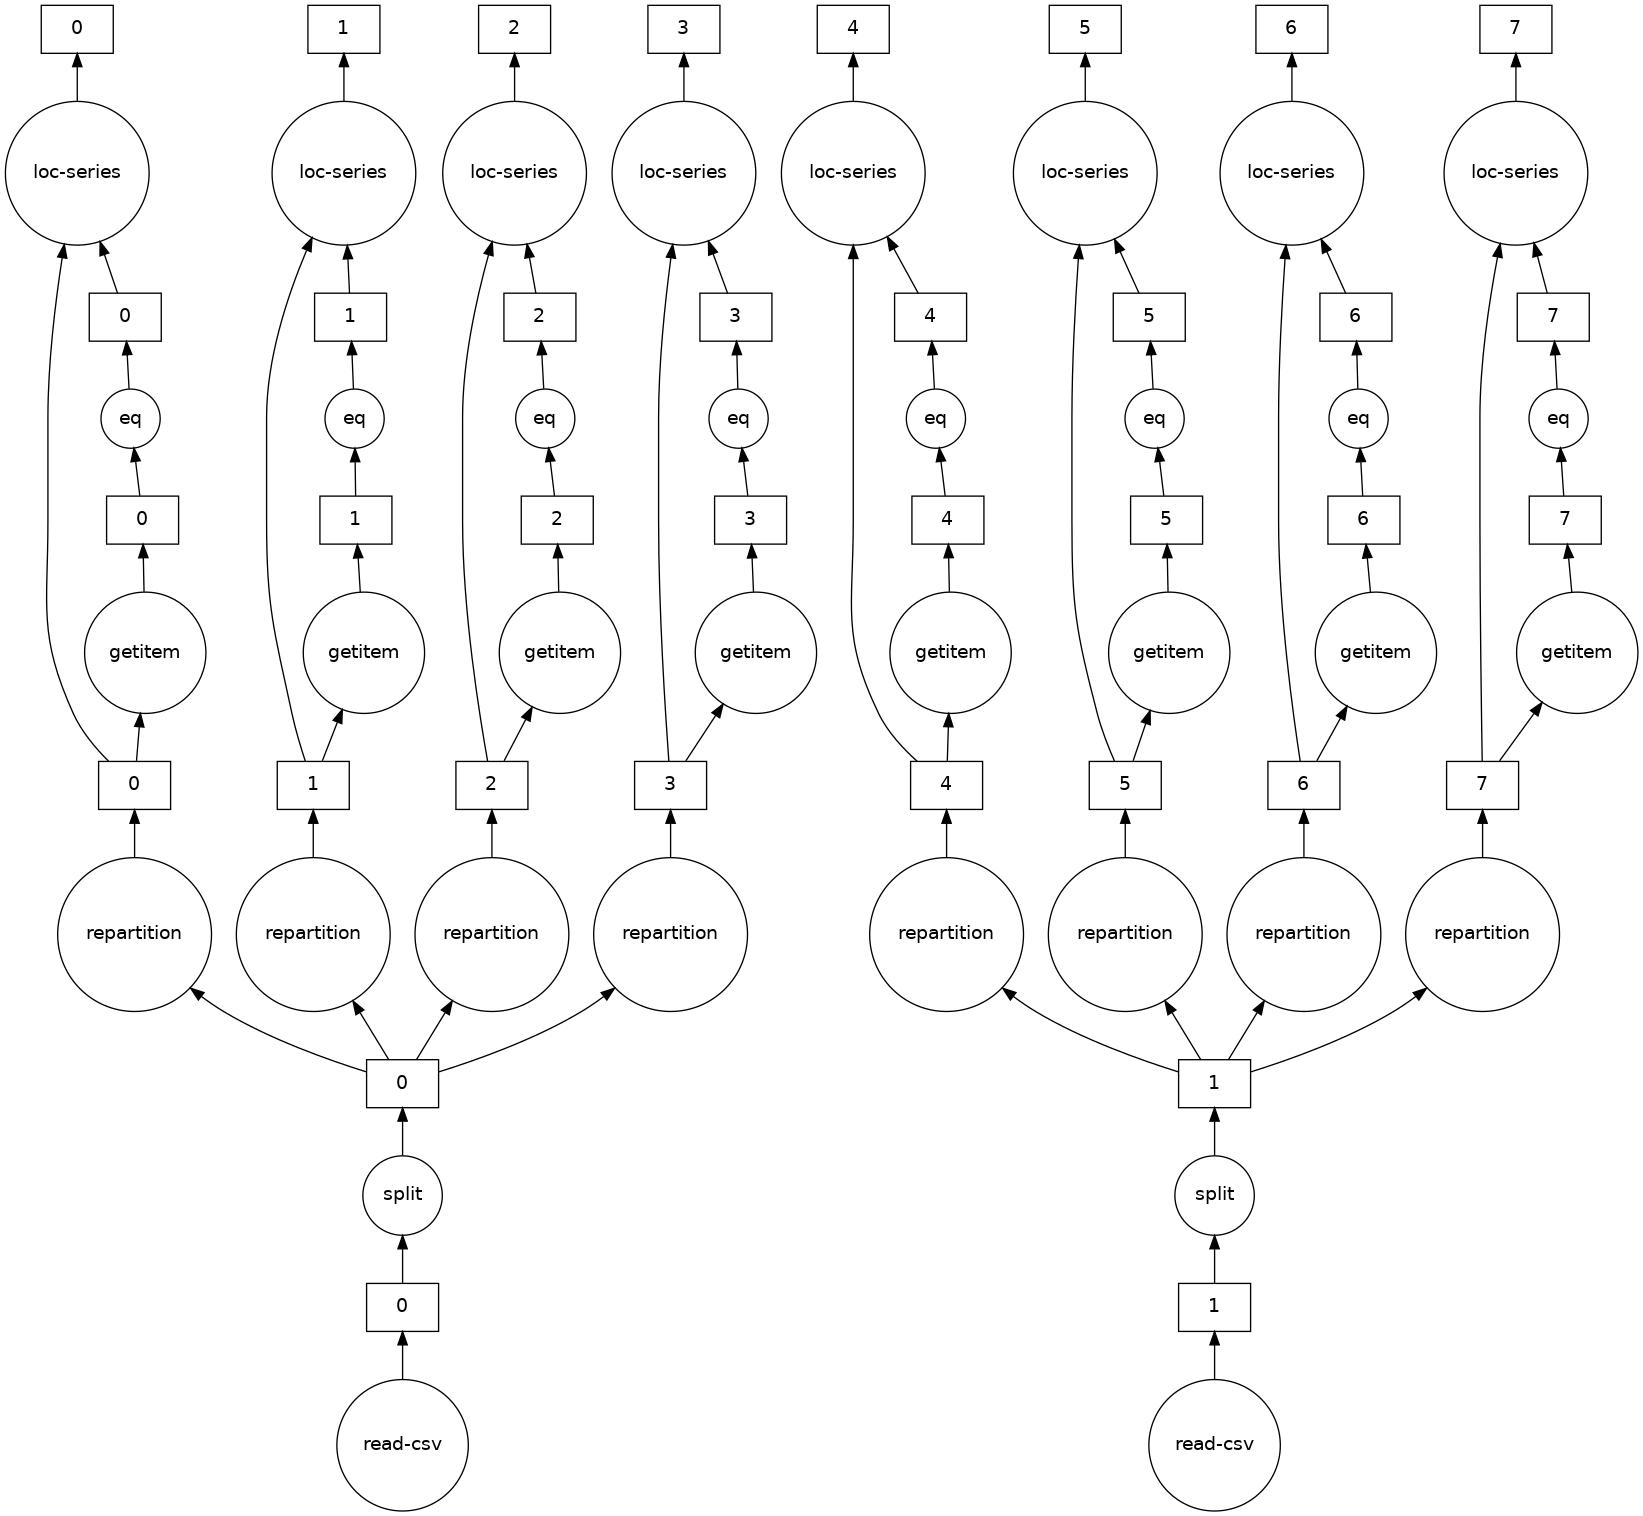

In [35]:
df.loc[df['Dest']=='DEN',['UniqueCarrier']].visualize()

`iloc` will raise instead an exception.

This happens because Dask DataFrame does not take into account the length of partitions and the row ordering inside the partition.
After all, what is the real odering of rows when the records are sharded across multiple nodes...? 

We can still use `iloc` to select the index of a some column, but for all rows in all partitions, e.g.: `iloc[:,0:10]`

This makes `iloc` extremely inefficient in Dask.

In [36]:
df.iloc[0:10]

NotImplementedError: 'DataFrame.iloc' only supports selecting columns. It must be used like 'df.iloc[:, column_indexer]'.

Other very ineffienct operations in Dask are all the actions that require a re-indexing of the entire DataFrame, or sorting or merging of the entries based on a column that is not the index of the DataFrame itself.

This is due to the optimization Dask runs under the hood, where the range of the index column field can (although this might not always be the case) be used to subdivide the data into partitions.

Setting an index on a DataFrame will thus require to sort the entire dataset by the specified column, which is an extremely expensive process.
While the sorting process can be very slow, it can be extremely usefult to do it (although _very_ unfrequently) to speed up further computations.

Dask will in fact also use the index in merge/join operations. Performing a join on a column that is not the index of the DataFrame is also a very expensive operations.

After an unavoidable and expensive operation such a full reshuffling of your data is done (out of necessity), one can always persist the new DataFrame, to speed up subsequent computations.

In [37]:
df_reindexed = df[(df.UniqueCarrier=='UA') & (df['Dest']=='DEN')].set_index('Date')

In [38]:
df_reindexed.ArrDelay.rolling('5D').mean().compute()

Date
1993-01-01    11.000000
1993-01-01    11.500000
1993-01-01    14.000000
1993-01-01    14.500000
1993-01-01    13.800000
                ...    
1999-12-31    -7.283019
1999-12-31    -7.388889
1999-12-31    -7.163636
1999-12-31    -7.500000
1999-12-31    -7.543860
Name: ArrDelay, Length: 7850, dtype: float64

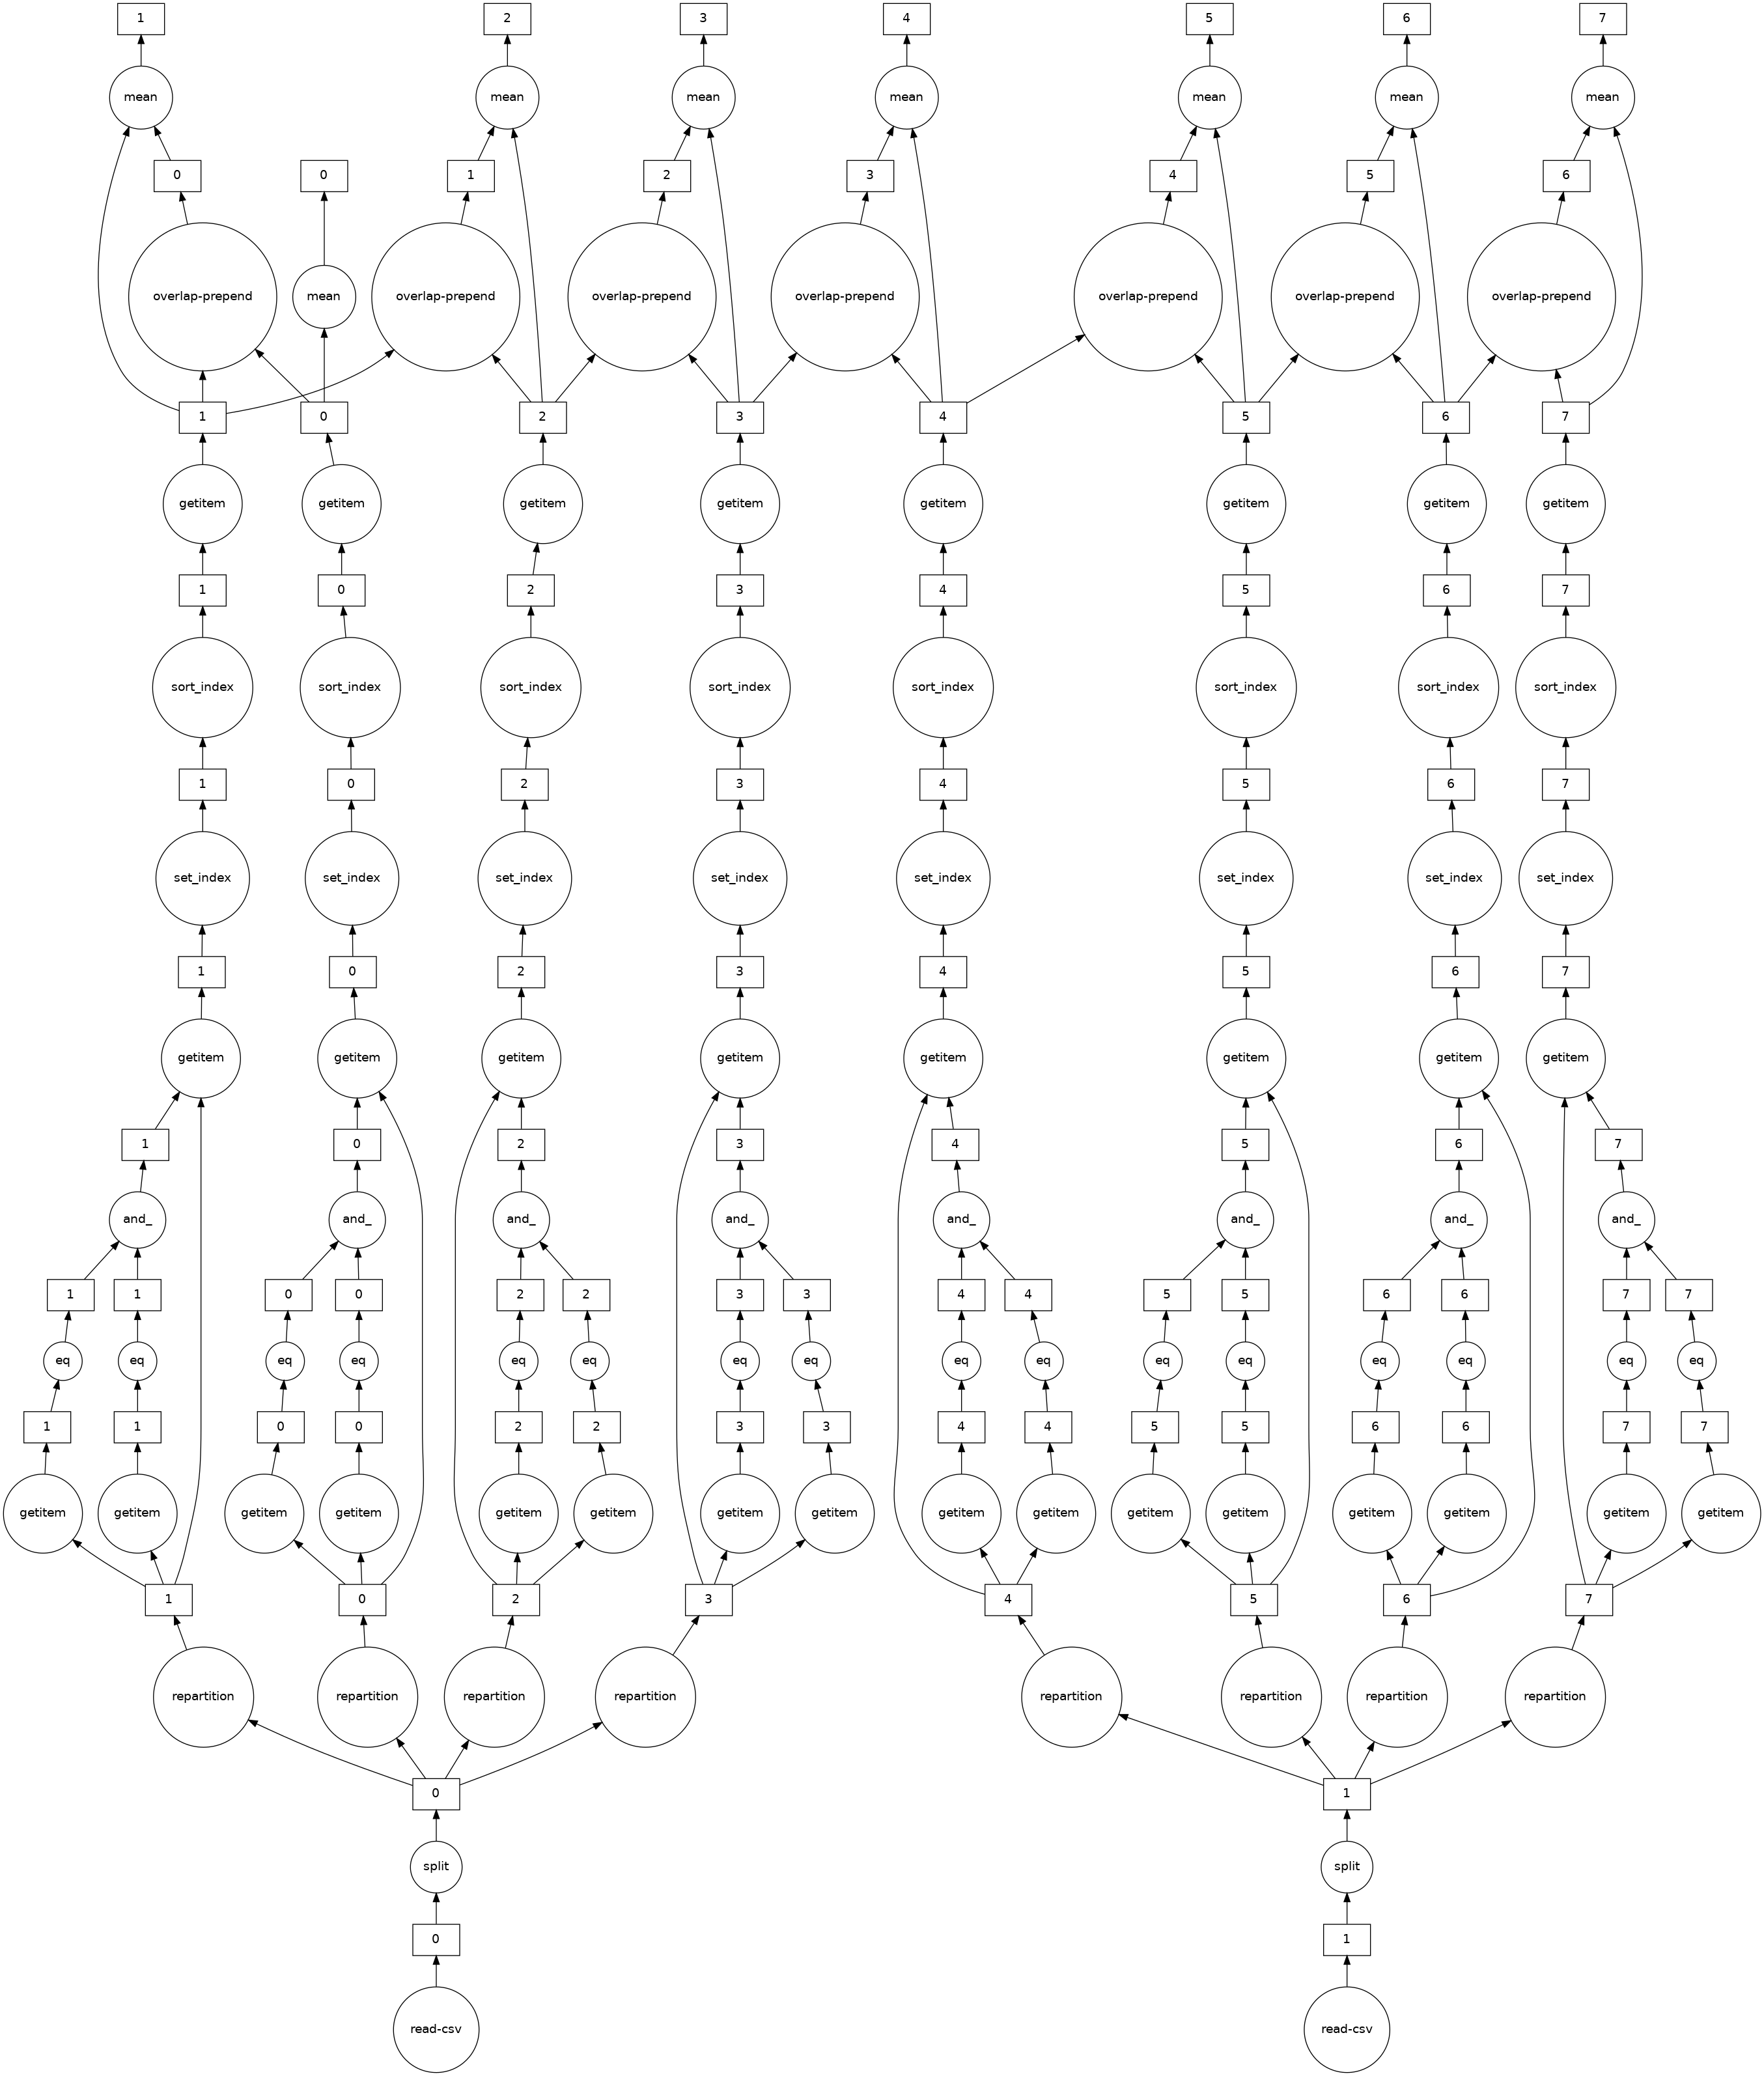

In [39]:
df_reindexed.ArrDelay.rolling('5D').mean().visualize()

### Shared, reapeated and intermediate computations

When computing all of the above, we sometimes have to repeat the same operation more than once. 

For most operations, Dask DataFrame _hashes_ the arguments allowing duplicate computations to be shared, and only computed once.

For example, lets compute the mean and standard deviation for departure delay of all non-canceled flights. 
Since dask operations are lazy, those values aren't the final results yet. 
They're just the recipe require to get the result.

If we want to change the approach, we can compute them with two individual calls to compute. 
In this latter case, there is no sharing of intermediate computations and an overall speedup of the computation.

In [40]:
df = df.persist()

In [41]:
df.head()

Date  DayOfWeek  DepTime  CRSDepTime  ArrTime  CRSArrTime  \
0 1993-01-29          5   1055.0        1055   1228.0        1212   
1 1993-01-30          6   1052.0        1055   1214.0        1212   
2 1993-01-31          7   1103.0        1055   1213.0        1212   
3 1993-01-03          7   1736.0        1729   1838.0        1831   
4 1993-01-04          1   1730.0        1729   1825.0        1831   

  UniqueCarrier  FlightNum TailNum  ActualElapsedTime  ...  AirTime  ArrDelay  \
0            US         66     NaN               93.0  ...      NaN      16.0   
1            US         66     NaN               82.0  ...      NaN       2.0   
2            US         66     NaN               70.0  ...      NaN       1.0   
3            US         70     NaN               62.0  ...      NaN       7.0   
4            US         70     NaN               55.0  ...      NaN      -6.0   

   DepDelay  Origin Dest Distance  TaxiIn  TaxiOut  Cancelled  Diverted  
0       0.0     EWR  BUF    282.0     NaN      NaN          0         0  
1      -3.0     EWR  BUF    282.0     NaN      NaN          0         0  
2       8.0     EWR  BUF    282.0     NaN      NaN          0         0  
3       7.0     LGA  SYR    198.0     NaN      NaN          0         0  
4       1.0     LGA  SYR    198.0     NaN      NaN          0         0  

[5 rows x 21 columns]

In [42]:
import dask

#create non-cancelled dataframe
non_cancelled = df[df.Cancelled==0]

# create mean DepDelay series
mean_delay    = non_cancelled.DepDelay.mean()

# create std DepDelay series
std_delay     = non_cancelled.DepDelay.std()

In [45]:
%%time

# compute the time to run both functions
mean_delay_res = mean_delay.compute()
std_delay_res = std_delay.compute()

CPU times: user 35.4 ms, sys: 0 ns, total: 35.4 ms
Wall time: 6.37 s


In [44]:
%%time

# compute the time to combining both functions into a single compute call
mean_delay_res, std_delay_res = dask.compute(mean_delay, std_delay)

CPU times: user 28.8 ms, sys: 487 µs, total: 29.3 ms
Wall time: 2.95 s


Using dask.compute takes ~ 1/2 of the time of the other call. 

This is because the task graphs for both results are merged when calling `dask.compute`, allowing shared operations to only be done once instead of twice. 
In particular, using dask.compute only does the following once:

+ the calls to the `read_csv` function
+ the filter on the cancelled flights
+ some of the necessary reductions (sum, count)

Let's see the computation graph:

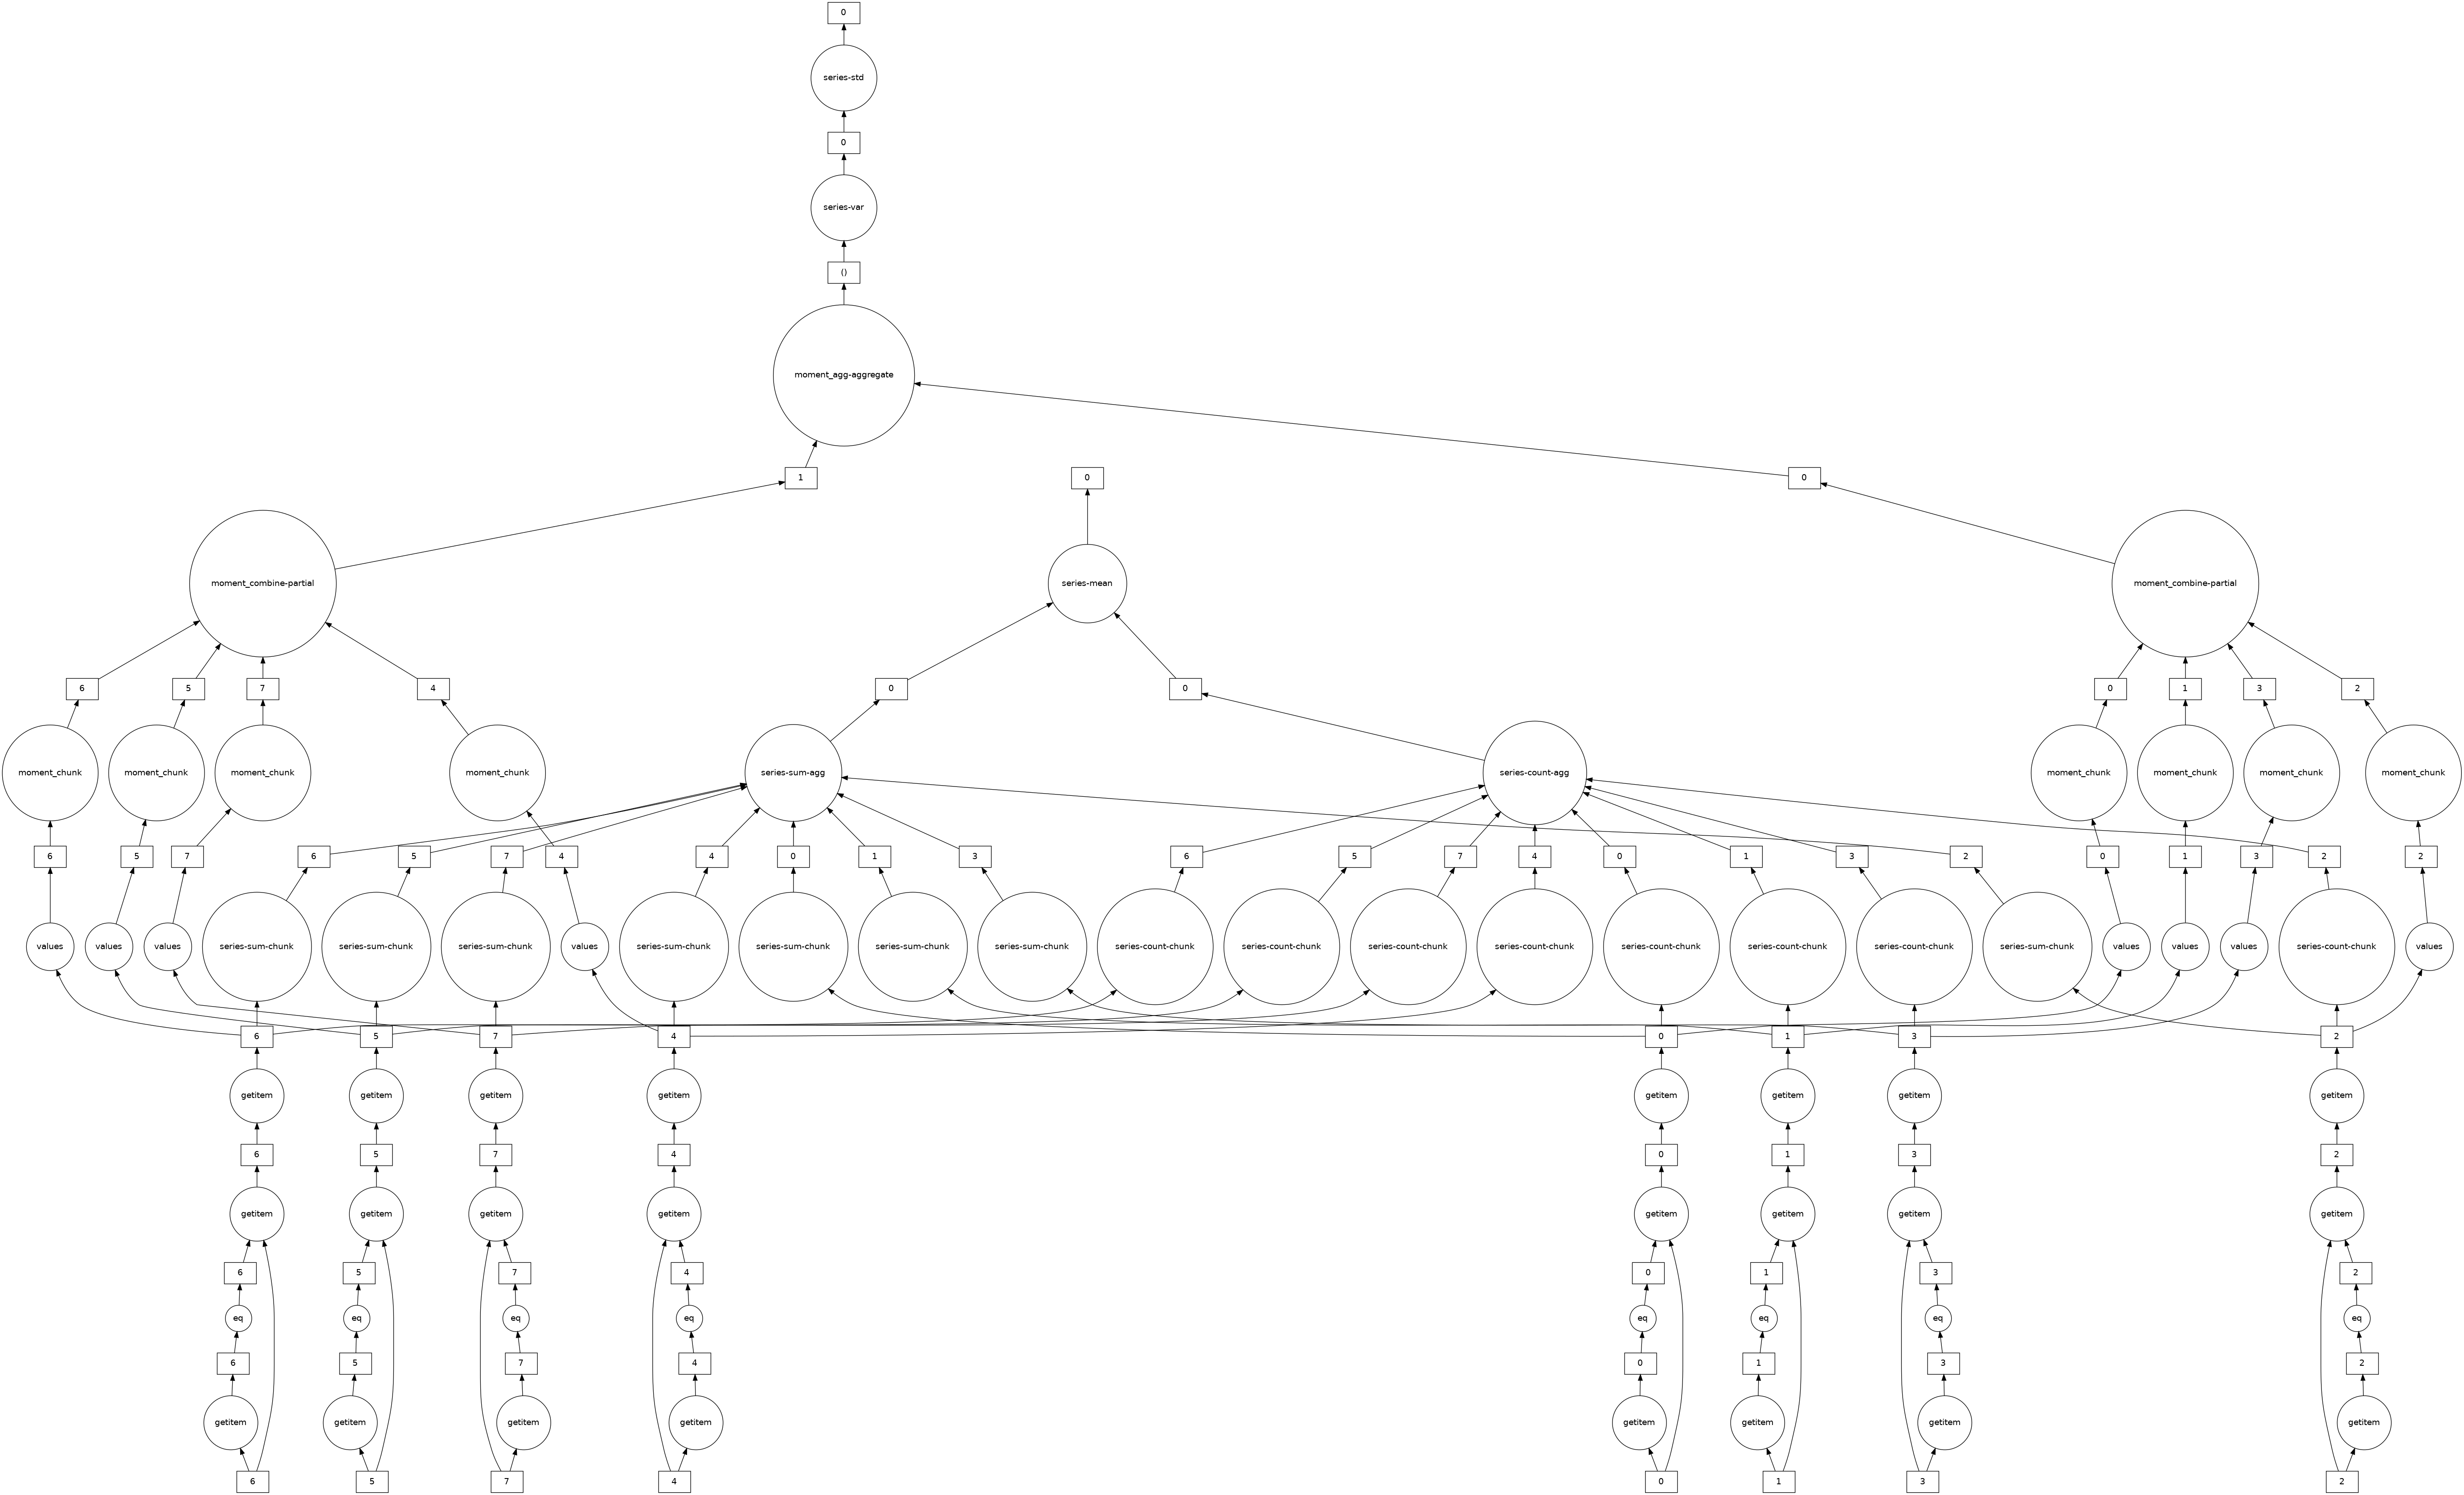

In [46]:
dask.visualize(mean_delay, std_delay)

What we can see is that a lot of operation have been merged and used one single time, thus resulting in a optimization of the computing time.

## Re-run the same example from the Spark notebook using Dask

To apply all we discussed about Dask high- and low-level APIs, we can re-run the same task we used as an example analysis pipeline in pySpark for the DiMuon invariant mass of the LHC collision data.

Starting from the JSON files already used in the previous pySpark example we will need to:
1. load all files using the Dask Bag API
2. parse the json event collections into python dictionaries
3. use a foldby to count the number of events per sample (mc and data)
4. plot the distribution of the number of muons in the mc and data sample from the Dask.Bag object
5. select only events with exactly 2 muons with opposite charge and fill a Dask.DataFrame with the normalized results
6. create the tranverse momemta $p_{T,1}$ and $p_{T,2}$ features and create a 2d plot of these features
$$p_T = \sqrt{p_x^2 + p_y^2}$$
7. retain only the dimuon pairs where both muons' $p_T$ is greater than 15 (GeV)
8. create the components of the dimuon 4-momentum
$$(E,P_x,P_y,P_z) = (E_1+E_2,p_{x,1}+p_{x,2},p_{y,1}+p_{y,2},p_{z,1}+p_{z,2})$$
9. create and plot the invariant mass spectrum
$$M = \sqrt{E^2 - (P_x^2 + P_y^2 + P_z^2) }$$

Before starting, from a terminal (external to the docker container you are working in), copy the `MAPD-B/spark/datasets/lecture2/dimuon` folder into the `MAPD-B/dask/notebooks/datasets/.` path

In [8]:
client.restart()

<Client: 'tcp://172.19.0.2:8786' processes=0 threads=0, memory=0 B>

In [6]:
# load the dimuon json files in a bag, each containing the text lines
import os
import dask.bag as db
from pprint import pprint

db_lines = db.read_text(os.path.join('datasets','dimuon','*.json'), files_per_partition=4)

pprint(db_lines.take(1))

('[{"nMuon": 2, "Muons": [{"E": 17.492634165117938, "px": 10.757375665111066, '
 '"py": -0.36882897785125973, "pz": -13.788543082169678, "charge": -1}, {"E": '
 '18.304746953915025, "px": -12.996993567586063, "py": 8.872220922130193, '
 '"pz": 9.349569587383566, "charge": -1}], "sample": "data"}, {"nMuon": 2, '
 '"Muons": [{"E": 11.518019014184631, "px": 10.143103318225762, "py": '
 '-2.8595861207964313, "pz": 4.646915171819817, "charge": 1}, {"E": '
 '17.333190062780094, "px": -13.458613971936328, "py": 9.24336542676646, "pz": '
 '-5.818437900634656, "charge": -1}], "sample": "data"}, {"nMuon": 1, "Muons": '
 '[{"E": 15.121118467960368, "px": 1.1150457745462625, "py": '
 '-3.0796812399008213, "pz": -14.761751129618265, "charge": 1}], "sample": '
 '"data"}, {"nMuon": 4, "Muons": [{"E": 29.141155937086687, "px": '
 '-5.5445853983524325, "py": -9.994155440520673, "pz": 26.80616040111144, '
 '"charge": 1}, {"E": 52.32902144116705, "px": 17.079891896645197, "py": '
 '4.385934314126088, "pz

 '"Muons": [{"E": 22.313463991853276, "px": -12.726210094516777, "py": '
 '18.27428805454489, "pz": -1.4048075864311773, "charge": 1}, {"E": '
 '9.215417660854724, "px": -6.12885169720257, "py": 6.844805595332066, "pz": '
 '-0.7060964588678428, "charge": 1}], "sample": "data"}, {"nMuon": 2, "Muons": '
 '[{"E": 8.903622332129522, "px": -2.5999364955059723, "py": '
 '7.661897058099783, "pz": -3.714699265490829, "charge": -1}, {"E": '
 '23.795898982837357, "px": -13.325260332113999, "py": 19.051635513366243, '
 '"pz": 5.070134717939539, "charge": 1}], "sample": "data"}, {"nMuon": 4, '
 '"Muons": [{"E": 71.51338156231223, "px": 12.462761597705311, "py": '
 '7.0662036725456865, "pz": -70.06354913793011, "charge": 1}, {"E": '
 '53.09292388779493, "px": 9.658083816753743, "py": 7.914029011673358, "pz": '
 '-51.603652632885996, "charge": -1}, {"E": 41.12903851707163, "px": '
 '6.660272459018288, "py": 3.8142926974828146, "pz": -40.4064176541024, '
 '"charge": 1}, {"E": 17.009213408126058, "px"

 '29.575777903593984, "pz": 7.332528549349567, "charge": 1}], "sample": '
 '"data"}, {"nMuon": 4, "Muons": [{"E": 30.73312574730257, "px": '
 '-9.3888159734768, "py": -4.50122033947278, "pz": -28.91544577869482, '
 '"charge": -1}, {"E": 7.724843876495794, "px": -2.7247668484296854, "py": '
 '-1.3222074011223781, "pz": 7.10559374266323, "charge": 1}, {"E": '
 '11.638446296526535, "px": -3.511895615906622, "py": 0.519552927599067, "pz": '
 '11.083272190330609, "charge": 1}, {"E": 31.133658933650526, "px": '
 '-9.526383913224592, "py": -4.561800513222045, "pz": -29.287054145504708, '
 '"charge": -1}], "sample": "data"}, {"nMuon": 2, "Muons": [{"E": '
 '35.516832259249206, "px": -12.368932226010411, "py": -5.167365573441449, '
 '"pz": 32.88984734929372, "charge": 1}, {"E": 19.398140856878793, "px": '
 '-7.685771606594131, "py": -4.474421422112868, "pz": 17.23905950918854, '
 '"charge": -1}], "sample": "data"}, {"nMuon": 1, "Muons": [{"E": '
 '9.487415589568377, "px": 7.011914666444703, "py

 '123.93570026882975, "px": 21.11263522849008, "py": 15.958191345778022, "pz": '
 '-121.07699781591418, "charge": -1}, {"E": 41.992801115224765, "px": '
 '0.4378041426428144, "py": 9.212734463375153, "pz": -40.967280029949166, '
 '"charge": 1}, {"E": 70.34356376911695, "px": 3.202910335720464, "py": '
 '14.063517194432103, "pz": -68.84885365459976, "charge": -1}], "sample": '
 '"data"}, {"nMuon": 3, "Muons": [{"E": 7.381994681833031, "px": '
 '0.49223760286979534, "py": -3.842482252684419, "pz": 6.28297016323983, '
 '"charge": 1}, {"E": 12.345754179284308, "px": 8.040119068103525, "py": '
 '-5.226263792163818, "pz": 7.774904160835426, "charge": -1}, {"E": '
 '5.956970180953233, "px": 4.836532466522803, "py": -1.3162777020794056, "pz": '
 '3.217094458897646, "charge": 1}], "sample": "data"}, {"nMuon": 2, "Muons": '
 '[{"E": 94.22595878461449, "px": 3.5145627007238716, "py": 45.73021076564079, '
 '"pz": 82.30987679216902, "charge": 1}, {"E": 95.19043303083471, "px": '
 '38.97286228613308

 '5.373819303811868, "pz": -4.443165639806612, "charge": -1}], "sample": '
 '"data"}, {"nMuon": 4, "Muons": [{"E": 3.844309525879487, "px": '
 '0.9139607099805727, "py": -3.5911757345894078, "pz": 1.0176859555385107, '
 '"charge": -1}, {"E": 7.679133697986937, "px": -2.35830913759267, "py": '
 '6.784172579541919, "pz": 2.715015853272594, "charge": 1}, {"E": '
 '28.985869589406718, "px": -16.932274669795856, "py": 22.621824848951942, '
 '"pz": -6.459147557801089, "charge": -1}, {"E": 6.4220940575904, "px": '
 '1.9762779862246627, "py": -6.069151207774139, "pz": -0.701325411132354, '
 '"charge": -1}], "sample": "data"}, {"nMuon": 2, "Muons": [{"E": '
 '21.90679651103603, "px": 10.116241240067636, "py": -6.6368245827275265, '
 '"pz": 18.2622778512491, "charge": -1}, {"E": 12.063757566881229, "px": '
 '-7.993638654704749, "py": 8.598576394983052, "pz": 2.7729601474884107, '
 '"charge": 1}], "sample": "data"}, {"nMuon": 2, "Muons": [{"E": '
 '17.26214844049004, "px": 12.438092464575996, "py

 '21.190104951502487, "charge": 1}, {"E": 20.643671022523595, "px": '
 '-2.007350210072896, "py": -15.728028484087783, "pz": 13.2192910072155, '
 '"charge": -1}], "sample": "data"}, {"nMuon": 4, "Muons": [{"E": '
 '8.679581710011435, "px": 4.972341499636387, "py": 6.713530766125968, "pz": '
 '2.351233640764649, "charge": 1}, {"E": 6.647080846902854, "px": '
 '1.348168743929477, "py": 6.357773005307447, "pz": 1.3905695040388408, '
 '"charge": 1}, {"E": 7.096759769991269, "px": 3.665493065720021, "py": '
 '5.37118301969824, "pz": 2.8403149643049774, "charge": -1}, {"E": '
 '8.242554980615349, "px": 4.299913978412389, "py": 6.703988928369333, "pz": '
 '2.1203351490852973, "charge": 1}], "sample": "data"}, {"nMuon": 2, "Muons": '
 '[{"E": 20.717876630478898, "px": -4.658901157233317, "py": '
 '-12.925999911654749, "pz": 15.505883227865468, "charge": 1}, {"E": '
 '10.844099720104653, "px": -8.256301869296832, "py": 2.85424730194907, "pz": '
 '6.424179856710149, "charge": -1}], "sample": "da

 '50.80048297600039, "charge": 1}, {"E": 15.257283168036958, "px": '
 '-3.697417451436415, "py": 14.474247004661313, "pz": 3.098193637743593, '
 '"charge": -1}, {"E": 21.454815538434175, "px": 0.13480524877701794, "py": '
 '-4.374096708367462, "pz": 21.003500937424985, "charge": -1}], "sample": '
 '"data"}, {"nMuon": 3, "Muons": [{"E": 21.494418429003044, "px": '
 '-3.152998408306739, "py": 3.140626591110615, "pz": -21.02840758504824, '
 '"charge": 1}, {"E": 18.783137271121074, "px": -10.024685629279222, "py": '
 '10.67432374426733, "pz": -11.762634598247773, "charge": -1}, {"E": '
 '17.929132655614772, "px": -10.154712342161417, "py": 7.103218013642072, '
 '"pz": -12.956417143280078, "charge": 1}], "sample": "data"}, {"nMuon": 2, '
 '"Muons": [{"E": 15.16121374897223, "px": 6.7280034997577, "py": '
 '4.83228561474948, "pz": 12.697803876898654, "charge": 1}, {"E": '
 '27.407276012591883, "px": 13.810861192671172, "py": 8.524036129873968, "pz": '
 '22.085029678793543, "charge": -1}], "s

 '"pz": 3.9324777359628227, "charge": 1}, {"E": 10.382606102679542, "px": '
 '8.106271937683866, "py": 0.7484311522176491, "pz": -6.4432563099361655, '
 '"charge": -1}, {"E": 4.865772045773539, "px": -4.619547487208021, "py": '
 '-1.4794820058379141, "pz": 0.368086835797781, "charge": 1}], "sample": '
 '"data"}, {"nMuon": 1, "Muons": [{"E": 31.01643135083187, "px": '
 '-2.7271657529073647, "py": -7.538840087800075, "pz": -29.9622480320993, '
 '"charge": -1}], "sample": "data"}, {"nMuon": 1, "Muons": [{"E": '
 '12.211154093128098, "px": -10.065337793015944, "py": 4.583055701600616, '
 '"pz": 5.175489942416529, "charge": 1}], "sample": "data"}, {"nMuon": 4, '
 '"Muons": [{"E": 19.029717105041634, "px": -5.031979869793222, "py": '
 '2.4147301133765056, "pz": -18.19250467849018, "charge": -1}, {"E": '
 '18.561535758259982, "px": -4.844181672219609, "py": -1.9196070692505443, '
 '"pz": -17.814838159264976, "charge": 1}, {"E": 5.092614743526513, "px": '
 '-3.937684352090057, "py": 3.22089957

 '8.276394098117583, "charge": 1}], "sample": "data"}, {"nMuon": 3, "Muons": '
 '[{"E": 54.607312451385425, "px": -13.907258737741309, "py": '
 '-0.5430493614402208, "pz": -52.80379400445782, "charge": 1}, {"E": '
 '39.91352645654475, "px": 7.675492451705343, "py": -2.215545272685872, "pz": '
 '-39.10571064787362, "charge": 1}, {"E": 13.95308249494272, "px": '
 '-2.999243019777052, "py": -0.5066685523335558, "pz": -13.617091308590698, '
 '"charge": 1}], "sample": "data"}, {"nMuon": 1, "Muons": [{"E": '
 '46.69030518692767, "px": -14.803210118101225, "py": -34.739138785703425, '
 '"pz": -27.4596183765334, "charge": -1}], "sample": "data"}, {"nMuon": 1, '
 '"Muons": [{"E": 11.18001976233656, "px": 2.7914273030197596, "py": '
 '-10.757773927425397, "pz": -1.2082681548492151, "charge": -1}], "sample": '
 '"data"}, {"nMuon": 2, "Muons": [{"E": 51.23161745092474, "px": '
 '13.354689307503213, "py": -8.30836550913224, "pz": 48.75746916128894, '
 '"charge": 1}, {"E": 21.386618298084073, "px": 

 '"charge": 1}], "sample": "data"}, {"nMuon": 3, "Muons": [{"E": '
 '15.587242411058659, "px": -4.762287731078651, "py": 1.3286532182145956, '
 '"pz": 14.78195719391299, "charge": 1}, {"E": 8.434493262713623, "px": '
 '8.39146479109612, "py": -0.28364942351141176, "pz": -0.7952198265397008, '
 '"charge": 1}, {"E": 25.714859753515594, "px": 25.115081634338036, "py": '
 '-5.5144408552811885, "pz": 0.2578080808324121, "charge": -1}], "sample": '
 '"data"}, {"nMuon": 2, "Muons": [{"E": 31.37320453073166, "px": '
 '8.71091117977386, "py": 15.153835745609921, "pz": 26.052794234970495, '
 '"charge": 1}, {"E": 11.779206890116969, "px": 7.518897994756036, "py": '
 '8.943563791485177, "pz": 1.4890906358219254, "charge": -1}], "sample": '
 '"data"}, {"nMuon": 2, "Muons": [{"E": 99.16045808309376, "px": '
 '-3.9776650805171228, "py": -18.847908273339737, "pz": 97.27137203610025, '
 '"charge": -1}, {"E": 35.171609795646646, "px": 0.17243235004418958, "py": '
 '9.544482111271526, "pz": 33.8512052996

 '"data"}, {"nMuon": 1, "Muons": [{"E": 17.633346231228302, "px": '
 '-9.272463741788957, "py": 14.924765489121265, "pz": 1.482068443676574, '
 '"charge": -1}], "sample": "data"}, {"nMuon": 3, "Muons": [{"E": '
 '19.942020364892457, "px": 3.9699334347763715, "py": -16.79915964447403, '
 '"pz": 9.985032614174571, "charge": 1}, {"E": 22.199072470786692, "px": '
 '-6.404444568531031, "py": 21.25482465247716, "pz": 0.05633501332688602, '
 '"charge": -1}, {"E": 8.188306663674005, "px": 5.282542629981823, "py": '
 '-6.068035168795697, "pz": 1.5201627809139222, "charge": -1}], "sample": '
 '"data"}, {"nMuon": 2, "Muons": [{"E": 10.529726977226337, "px": '
 '5.039377041297828, "py": 8.516418130858158, "pz": 3.5971221525524295, '
 '"charge": 1}, {"E": 15.91162460745893, "px": 8.554284233382054, "py": '
 '12.386006935031672, "pz": 5.155549186844752, "charge": -1}], "sample": '
 '"data"}, {"nMuon": 1, "Muons": [{"E": 18.079334625818344, "px": '
 '-5.391269310383636, "py": -14.45824588930256, "pz"

 '-11.631524703520116, "py": -13.833654111422048, "pz": 4.479101026064803, '
 '"charge": -1}, {"E": 16.68650952490937, "px": 7.519347174275487, "py": '
 '14.614948286110662, "pz": -2.8794341633977183, "charge": -1}], "sample": '
 '"data"}, {"nMuon": 2, "Muons": [{"E": 90.12730701487484, "px": '
 '18.566046363359465, "py": 3.2427842641766644, "pz": 88.1345935414269, '
 '"charge": -1}, {"E": 8.81561850700034, "px": -8.453818471422315, "py": '
 '1.6291037851159569, "pz": 1.8928655736610496, "charge": 1}], "sample": '
 '"data"}, {"nMuon": 2, "Muons": [{"E": 16.907783063531813, "px": '
 '-10.319399089031545, "py": 12.410357412134367, "pz": 5.035374442606446, '
 '"charge": 1}, {"E": 15.599726611495235, "px": -9.333159295814228, "py": '
 '11.476911219261439, "pz": 4.951055754782461, "charge": -1}], "sample": '
 '"data"}, {"nMuon": 4, "Muons": [{"E": 23.044245406354218, "px": '
 '-4.812170177637338, "py": 7.2476571778149905, "pz": 21.33871051099449, '
 '"charge": 1}, {"E": 23.523748900023648, 

 '"charge": -1}, {"E": 8.832637953230087, "px": 1.559479781913994, "py": '
 '-4.376698683642795, "pz": 7.5111158268706, "charge": 1}], "sample": "data"}, '
 '{"nMuon": 2, "Muons": [{"E": 42.41936048254738, "px": -16.541581550969987, '
 '"py": -12.515513606225694, "pz": -37.00174291871554, "charge": 1}, {"E": '
 '41.98410218877493, "px": -17.502541241735635, "py": -12.789901453322656, '
 '"pz": -35.95459836797734, "charge": -1}], "sample": "data"}, {"nMuon": 2, '
 '"Muons": [{"E": 9.833658241155964, "px": 5.213584890786742, "py": '
 '-2.0677529016563, "pz": 8.076670182540036, "charge": -1}, {"E": '
 '23.585766941833423, "px": 13.150455408412236, "py": -0.22990132560110002, '
 '"pz": 19.57779115415616, "charge": 1}], "sample": "data"}, {"nMuon": 2, '
 '"Muons": [{"E": 30.815865559175098, "px": 19.105344260332572, "py": '
 '-24.13173925066945, "pz": 1.500462562830257, "charge": -1}, {"E": '
 '75.62440455155458, "px": -44.24410638124441, "py": 39.681987373129594, "pz": '
 '46.7636432362847

In [7]:
# extract the json structure from the lines
import json

db_js = db_lines.map(json.loads).flatten()

pprint(db_js.take(1))

({'Muons': [{'E': 17.492634165117938,
             'charge': -1,
             'px': 10.757375665111066,
             'py': -0.36882897785125973,
             'pz': -13.788543082169678},
            {'E': 18.304746953915025,
             'charge': -1,
             'px': -12.996993567586063,
             'py': 8.872220922130193,
             'pz': 9.349569587383566}],
  'nMuon': 2,
  'sample': 'data'},)


In [8]:
# count the number of events per each sample
from operator import add

def incr(tot, _):
    return tot + 1

db_js.foldby(key = 'sample', binop = incr, initial = 0, combine = add, combine_initial = 0).compute()

[('data', 25000), ('mc', 25000)]

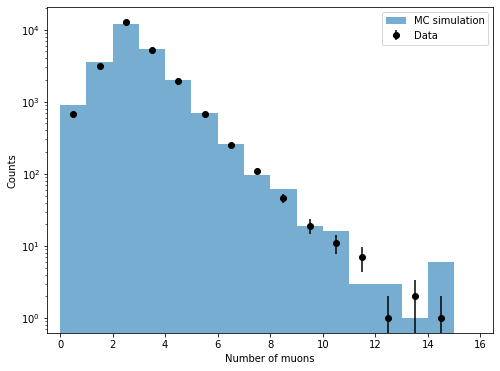

In [9]:
# plot the distribution of the number of muons in the mc and data sample
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(8,6))
mc_counts = db_js.filter(lambda record: record['sample'] == 'mc').pluck('nMuon').compute()

plt.hist(
    mc_counts,
    label = 'MC simulation', bins=range(16), alpha=0.6
)

data_counts = db_js.filter(lambda record: record['sample']=='data')\
                     .pluck('nMuon').compute()
data_counts, data_edges = np.histogram(data_counts,range(16))
data_centers = 0.5*(data_edges[1:] + data_edges[:-1]) 

plt.errorbar(
    data_centers,
    data_counts,
    yerr = np.sqrt(data_counts),
    label = 'Data', color='black', fmt='o'
)

plt.xlim(-0.5,16.5)
plt.xlabel("Number of muons")
plt.ylabel("Counts")
plt.legend()
plt.semilogy()
plt.show()

In [10]:
# select only events with exactly 2 muons with opposite charge and fill a dask dataframe with the results
def flatten_records(record):
    return {
        'sample': record['sample'],
        'E1':  record['Muons'][0]['E'],
        'px1': record['Muons'][0]['px'],
        'py1': record['Muons'][0]['py'],
        'pz1': record['Muons'][0]['pz'],
        'E2':  record['Muons'][1]['E'],
        'px2': record['Muons'][1]['px'],
        'py2': record['Muons'][1]['py'],
        'pz2': record['Muons'][1]['pz'],
    }

df = db_js.filter(lambda record: record['nMuon'] == 2)\
          .filter(lambda record: record['Muons'][0]['charge'] == -record['Muons'][1]['charge'])\
          .map(flatten_records)\
          .to_dataframe()

In [11]:
# create the new pT1 and pT2 features 
# pT = sqrt(px^2 + py^2)
df['pT1'] = np.sqrt((df['px1']**2) + (df['py1']**2))
df['pT2'] = np.sqrt((df['px2']**2) + (df['py2']**2))

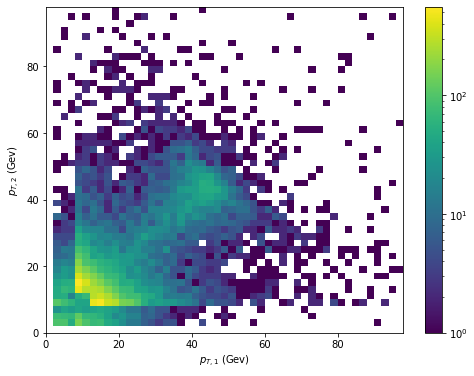

In [12]:
# plot the 2 dimensional distribution of the dimuon pair pTs in the mc sample
import matplotlib.colors as clt

plt.figure(figsize=(8,6))

plt.hist2d(
    df.loc[:,'pT1'],
    df.loc[:,'pT2'],
    label = 'MC simulation', 
    bins=(range(0,100,2),range(0,100,2)), 
    norm=clt.LogNorm()
)


plt.xlabel("$p_{T,1}$ (Gev)")
plt.ylabel("$p_{T,2}$ (Gev)")
plt.colorbar()
plt.show()

In [13]:
# retain only those dimuon pairs where both muons' pT is greater than 15 
df = df.loc[(df['pT1'] > 15) & (df['pT2'] > 15), :]

In [14]:
# create the 4-momentum features 
df['E'] = df['E1'] + df['E2']
df['Px'] = df['px1'] + df['px2']
df['Py'] = df['py1'] + df['py2']
df['Pz'] = df['pz1'] + df['pz2']
# and compute the invariant mass of the dimuon pair
# M = sqrt(E*E - (Px*Px + Py*Py + Pz*Pz))
df['M'] = np.sqrt((df['E']**2) - ((df['Px']**2) + (df['Py']**2) + (df['Pz']**2)))

In [15]:
# extract the slimmed down dataframe containing only the sample, Mass, and pT of the objects
# and store it in a Pandas DataFrame
pandas_df = df.loc[:,['sample','M','pT1','pT2']].compute()

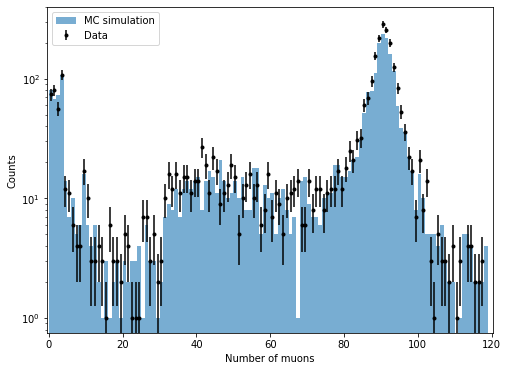

In [16]:
# plot the distribution of the dimuon invariant mass in the mc and data sample
plt.figure(figsize=(8,6))

plt.hist(
    pandas_df.loc[pandas_df['sample']=='mc','M'],
    label = 'MC simulation', bins=range(120), alpha=0.6
)

data_counts, data_edges = np.histogram(pandas_df.loc[pandas_df['sample']=='data','M'],range(120))
data_centers = 0.5*(data_edges[1:] + data_edges[:-1]) 

plt.errorbar(
    data_centers,
    data_counts,
    yerr = np.sqrt(data_counts),
    label = 'Data', color='black', fmt='.'
)

plt.xlim(-0.5,120.5)
plt.xlabel("Number of muons")
plt.ylabel("Counts")
plt.legend()
plt.semilogy()
plt.show()

### Memory management

In [ ]:
# to reclaim some memory from the workers
import ctypes

def trim_memory() -> int:
    libc = ctypes.CDLL("libc.so.6")
    return libc.malloc_trim(0)

client.run(trim_memory)

In [ ]:
# to restart the client
client.restart()